# CrossFit Open 2023 - Athletes Performance Analysis

<img src='References/2023_open_logo.jpeg'>

## Context

CrossFit is a fitness regimen brand developed and founded by Greg Glassman in 2000. It involves cross-disciplinary movements often performed at high intensity. Over the past two decades, CrossFit became a fitness methodology that was exponentially adopted worldwide. Since 2007, athletes of all levels are welcomed to participate at an annual competition called the CrossFit Games. In order to qualify for the CrossFit Games, athletes go through a series of qualification phases. The first phase is called the CrossFit Open (The Open). The Open is a series of weekly workouts that need to be performed as prescribed (Rx’d) to qualify for the next round, the Quarterfinals. 

## Objectives

The objectives of this project are as follows:

1.	Based on the Open 2023, we will evaluate the athletes’ profile, such as their age, height, weight, gender and their benchmark scores (if entered in their profile) to determine how well they would have performed at each test in 2023. We will use regression to understand how each variable of an athlete’s profile would impact their scores.

2.	CrossFit is a multidisciplinary sport that touches many fitness areas, mainly gymnastics, Olympic weightlifting and cardiovascular endurance. For CrossFit newcomers, with prior athletic experience, we would also want to know how well they would have performed in the Open 2023 tests. As such, we will use predictive modelling to evaluate their potential and if they would have qualified for the next round.


## Data

### Events Data

The CF Open data will come from the CrossFit’s API and will only include male and female Rx’d athletes events scores.

Male's Data:

https://c3po.crossfit.com/api/competitions/v2/competitions/open/2023/leaderboards?view=0&division=1&region=0&scaled=0&sort=0

Female's Data:

https://c3po.crossfit.com/api/competitions/v2/competitions/open/2023/leaderboards?view=0&division=2&region=0&scaled=0&sort=0

#### Key information:

Worlwide, there were 169,449 (56.1%) male competitors registered and 132,782 (43.9%) female competitors registered in the CrossFit Open 2023.
In total, there were 302,231 competitors registered.

### Benchmark Scores Data

The benchmark scores will come from the profile page of each athlete.

Athlete's Profile:

https://games.crossfit.com/athlete/{CompetitorId}

## Events Information

### Event 1 

Complete as many reps as possible in 14 minutes of:

60-calorie row
50 toes-to-bars
40 wall-ball shots
30 cleans
20 muscle-ups

♀ 14-lb ball to 9-ft target, 95-lb cleans
♂ 20-lb ball to 10-ft target, 135-lb cleans 

### Event 2

Complete as many reps as possible in 15 minutes of:

5 burpee pull-ups
10 shuttle runs (1 rep = 25 ft out/25 ft back)
*Add 5 burpee pull-ups after each round.

### Event 3

5 minutes to establish:

1-rep-max thruster (from the floor)

### Event 4

Starting with a 6-minute time cap, complete as many reps as possible of:


5 wall walks
50 double-unders
15 snatches (weight 1)
5 wall walks
50 double-unders
12 snatches (weight 2)

*If completed before the 6-minute time cap, add 3 minutes to the time cap and complete:

20 strict handstand push-ups
50 double-unders
9 snatches (weight 3)

*If completed before the 9-minute time cap, add 3 minutes to the time cap and complete:

20 strict handstand push-ups
50 double-unders
6 snatches (weight 4)


♀ 65 lb, 95 lb, 125 lb, 155 lb
♂ 95 lb, 135 lb, 185 lb, 225 lb



## Import all relevant libraries

In [2]:
# For the data
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np

# For the analysis
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# For the paralle processing
import concurrent.futures

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

# For saving models
import pickle

2023-08-29 20:17:25.487489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Get CrossFit Open Events data through Web Scraping

Using API requests, we'll loop through each page, get the data into a json format and create a list containg each json files.

In [ ]:
# Get male competitors data
MaleResponse_List = []
def get_MaleLeaderboardDetails():

    url ="https://c3po.crossfit.com/api/competitions/v2/competitions/open/2023/leaderboards?view=0&division=1&region=0&scaled=0&sort=0"
    # total pages is 3389 for divions = 1 (Male)
    for page in range (1,3389+1):
        response_data=requests.get(url, params = {'page': page}).json()
        MaleResponse_List.append(response_data)

get_MaleLeaderboardDetails()

In [ ]:
# Get female competitors data
FemaleResponse_List = []
def get_FemaleLeaderboardDetails():

    url ="https://c3po.crossfit.com/api/competitions/v2/competitions/open/2023/leaderboards?view=0&division=2&region=0&scaled=0&sort=0"
    # total pages is 2656 for divions = 2 (Female)
    for page in range (1,2656+1):
        response_data=requests.get(url, params = {'page': page}).json()
        FemaleResponse_List.append(response_data)

get_FemaleLeaderboardDetails()

## Create raw dataframe of all competitors for each gender

This will loop through each and each competitor to get the necessary information

In [ ]:
# Create a dataframe that contains one line for every male competitor
MaleEntries_List = []

# Loop over all events for all competitors
for page in range(0,len(MaleResponse_List)-1):
    for i in range(0,len(MaleResponse_List[page]['leaderboardRows'])-1):
        competitorData = MaleResponse_List[page]['leaderboardRows'][i]
        page_entries = pd.DataFrame({
                                    'CompetitorId': [competitorData['entrant']['competitorId']],
                                    'CompetitorName': [competitorData['entrant']['competitorName']],
                                    'Gender': [competitorData['entrant']['gender']],
                                    'Height': [competitorData['entrant']['height']],
                                    'Weight': [competitorData['entrant']['weight']],
                                    'Age': [competitorData['entrant']['age']],
                                    'CountryOfOriginName': [competitorData['entrant']['countryOfOriginName']],
                                    'RegionName': [competitorData['entrant']['regionName']],
                                    'AffiliateName': [competitorData['entrant']['affiliateName']],
                                    'OverallRank': [competitorData['overallRank']],
                                    'OverallScore': [competitorData['overallScore']],
                                    'Event 1 - Rank': [competitorData['scores'][0]['rank']],
                                    'Event 1 - Score': [competitorData['scores'][0]['scoreDisplay']],
                                    'Event 1 - Scaled': [competitorData['scores'][0]['scaled']],                                                                     
                                    'Event 2 - Rank': [competitorData['scores'][1]['rank']],
                                    'Event 2 - Score': [competitorData['scores'][1]['scoreDisplay']],
                                    'Event 2 - Scaled': [competitorData['scores'][1]['scaled']],
                                    'Event 3 - Rank': [competitorData['scores'][2]['rank']],
                                    'Event 3 - Score': [competitorData['scores'][2]['scoreDisplay']],
                                    'Event 3 - Scaled': [competitorData['scores'][2]['scaled']],
                                    'Event 4 - Rank': [competitorData['scores'][3]['rank']],
                                    'Event 4 - Score': [competitorData['scores'][3]['scoreDisplay']],
                                    'Event 4 - Scaled': [competitorData['scores'][3]['scaled']],                                                                                                                                     
                                    })
        MaleEntries_List.append(page_entries)

Males_df = pd.concat([*MaleEntries_List],ignore_index=True)



In [ ]:
# Create a dataframe that contains one line for every female competitor
FemaleEntries_List = []

# Loop over all events for all competitors
for page in range(0,len(FemaleResponse_List)-1):
    for i in range(0,len(FemaleResponse_List[page]['leaderboardRows'])-1):
        competitorData = FemaleResponse_List[page]['leaderboardRows'][i]
        page_entries = pd.DataFrame({
                                    'CompetitorId': [competitorData['entrant']['competitorId']],
                                    'CompetitorName': [competitorData['entrant']['competitorName']],
                                    'Gender': [competitorData['entrant']['gender']],
                                    'Height': [competitorData['entrant']['height']],
                                    'Weight': [competitorData['entrant']['weight']],
                                    'Age': [competitorData['entrant']['age']],
                                    'CountryOfOriginName': [competitorData['entrant']['countryOfOriginName']],
                                    'RegionName': [competitorData['entrant']['regionName']],
                                    'AffiliateName': [competitorData['entrant']['affiliateName']],
                                    'OverallRank': [competitorData['overallRank']],
                                    'OverallScore': [competitorData['overallScore']],
                                    'Event 1 - Rank': [competitorData['scores'][0]['rank']],
                                    'Event 1 - Score': [competitorData['scores'][0]['scoreDisplay']],
                                    'Event 1 - Scaled': [competitorData['scores'][0]['scaled']],                                                                     
                                    'Event 2 - Rank': [competitorData['scores'][1]['rank']],
                                    'Event 2 - Score': [competitorData['scores'][1]['scoreDisplay']],
                                    'Event 2 - Scaled': [competitorData['scores'][1]['scaled']],
                                    'Event 3 - Rank': [competitorData['scores'][2]['rank']],
                                    'Event 3 - Score': [competitorData['scores'][2]['scoreDisplay']],
                                    'Event 3 - Scaled': [competitorData['scores'][2]['scaled']],
                                    'Event 4 - Rank': [competitorData['scores'][3]['rank']],
                                    'Event 4 - Score': [competitorData['scores'][3]['scoreDisplay']],
                                    'Event 4 - Scaled': [competitorData['scores'][3]['scaled']],                                                                                                                                     
                                    })
        FemaleEntries_List.append(page_entries)

Females_df = pd.concat([*FemaleEntries_List],ignore_index=True)



Due to the size of the data, we will store the data into csv files. For ease of access in the future, we can simply read the data directly from the saved files.

In [ ]:
Males_df.to_csv('Males_df.csv',index=False)
Females_df.to_csv('Females_df.csv',index=False)

## Clean the Events dataframes

This cleaning process allow us to remove any outliers data and ensure usability of the values for the analysis. We're also creating two columns. One is for the body mass index (BMI) to be used as a predictor and the binary column 'QualifiedForQF' is to determine whether the athlete was part of the 90th percentile and above to move forward to the Quarterfinals.

In [ ]:
# Create another dataframe to clean data
Males_df_clean = Males_df
Males_df_clean = Males_df_clean.replace('',np.nan)
Males_df_clean = Males_df_clean.dropna()

# Only include athletes who did the events as prescribed (Rx'd)
Males_df_clean = Males_df_clean[(Males_df_clean['Event 1 - Scaled']== '0') &
                      (Males_df_clean['Event 2 - Scaled']== '0') &
                      (Males_df_clean['Event 3 - Scaled']== '0') &
                      (Males_df_clean['Event 4 - Scaled']== '0')]

# Convert height into centimeters
Males_df_clean['HeightInCm'] = [int(height[:-2])
            if height[-2:] == 'cm'
            else int(round(int(height[:-2])*2.54,0))
            for height in Males_df_clean['Height']]
# Convert weight into kilograms
Males_df_clean['WeightInKg'] = [int(weight[:-2])
            if weight[-2:] == 'kg'
            else int(round(int(weight[:-2])/2.205,0))
            for weight in Males_df_clean['Weight']]
# Convert string scores into integers by removing the units of measure
Males_df_clean['Event 1 - Score'] = Males_df_clean['Event 1 - Score'].apply(lambda x: x.replace('reps',''))
Males_df_clean['Event 2 - Score'] = Males_df_clean['Event 2 - Score'].apply(lambda x: x.replace('reps',''))
Males_df_clean['Event 3 - Score'] = Males_df_clean['Event 3 - Score'].apply(lambda x: x.replace('lbs',''))

# Event 4 contains only 1% of competitors who finished within the time cap. Therefore, we will assign the max reps to those who successfully completed.
# Everyone else will have their actual score.
Males_df_clean['Event 4 - Score'] = ['292 reps'
                                    if score[-4:] != 'reps'
                                    else score
                                    for score in Males_df_clean['Event 4 - Score']]
Males_df_clean['Event 4 - Score'] = Males_df_clean['Event 4 - Score'].apply(lambda x: x.replace('reps',''))

# Calculate BMI based on weight and height
Males_df_clean['BMI'] = round(Males_df_clean['WeightInKg']/((Males_df_clean['HeightInCm']/100)**2),1)

# Using BMI as an indicator, exclude athletes who input incorrectly their weight and height
Males_df_clean = Males_df_clean[(Males_df_clean['BMI']>=15) & (Males_df_clean['BMI']<=40)]

# Convert below columns into integer
Males_df_clean = Males_df_clean.astype({'Age':'int',
                                        'OverallRank':'int',
                                        'OverallScore':'int',
                                        'Event 1 - Rank':'int',
                                        'Event 1 - Score':'int',
                                        'Event 1 - Scaled':'int',
                                        'Event 2 - Rank':'int',
                                        'Event 2 - Score':'int',
                                        'Event 2 - Scaled':'int',
                                        'Event 3 - Rank':'int',
                                        'Event 3 - Score':'int',
                                        'Event 3 - Scaled':'int',
                                        'Event 4 - Rank':'int',
                                        'Event 4 - Score':'int',
                                        'Event 4 - Scaled':'int',
                                        })

# Determine whether the Athlete qualified for Quarterfinals (Top 10% of all competitors)
Males_df_clean['QualifiedForQF'] = [True
                                    if rank<=16945 # 10% of 169449 male competitors
                                    else False
                                    for rank in Males_df_clean['OverallRank']]

MalesRxEvents_df = Males_df_clean

In [ ]:
# Create another dataframe to clean data
Females_df_clean = Females_df
Females_df_clean = Females_df_clean.replace('',np.nan)
Females_df_clean = Females_df_clean.dropna()

# Only include athletes who did the events as prescribed (Rx'd)
Females_df_clean = Females_df_clean[(Females_df_clean['Event 1 - Scaled']== '0') &
                      (Females_df_clean['Event 2 - Scaled']== '0') &
                      (Females_df_clean['Event 3 - Scaled']== '0') &
                      (Females_df_clean['Event 4 - Scaled']== '0')]

# Convert height into centimeters
Females_df_clean['HeightInCm'] = [int(height[:-2])
            if height[-2:] == 'cm'
            else int(round(int(height[:-2])*2.54,0))
            for height in Females_df_clean['Height']]
# Convert weight into kilograms
Females_df_clean['WeightInKg'] = [int(weight[:-2])
            if weight[-2:] == 'kg'
            else int(round(int(weight[:-2])/2.205,0))
            for weight in Females_df_clean['Weight']]
# Convert string scores into integers by removing the units of measure
Females_df_clean['Event 1 - Score'] = Females_df_clean['Event 1 - Score'].apply(lambda x: x.replace('reps',''))
Females_df_clean['Event 2 - Score'] = Females_df_clean['Event 2 - Score'].apply(lambda x: x.replace('reps',''))
Females_df_clean['Event 3 - Score'] = Females_df_clean['Event 3 - Score'].apply(lambda x: x.replace('lbs',''))

# Event 4 contains only 1% of competitors who finished within the time cap. Therefore, we will assign the max reps to those who successfully completed.
# Everyone else will have their actual score.
Females_df_clean['Event 4 - Score'] = ['292 reps'
                                    if score[-4:] != 'reps'
                                    else score
                                    for score in Females_df_clean['Event 4 - Score']]
Females_df_clean['Event 4 - Score'] = Females_df_clean['Event 4 - Score'].apply(lambda x: x.replace('reps',''))

# Calculate BMI based on weight and height
Females_df_clean['BMI'] = round(Females_df_clean['WeightInKg']/((Females_df_clean['HeightInCm']/100)**2),1)

# Using BMI as an indicator, exclude athletes who input incorrectly their weight and height
Females_df_clean = Females_df_clean[(Females_df_clean['BMI']>=15) & (Females_df_clean['BMI']<=40)]

# Convert below columns into integer
Females_df_clean = Females_df_clean.astype({'Age':'int',
                                        'OverallRank':'int',
                                        'OverallScore':'int',
                                        'Event 1 - Rank':'int',
                                        'Event 1 - Score':'int',
                                        'Event 1 - Scaled':'int',
                                        'Event 2 - Rank':'int',
                                        'Event 2 - Score':'int',
                                        'Event 2 - Scaled':'int',
                                        'Event 3 - Rank':'int',
                                        'Event 3 - Score':'int',
                                        'Event 3 - Scaled':'int',
                                        'Event 4 - Rank':'int',
                                        'Event 4 - Score':'int',
                                        'Event 4 - Scaled':'int',
                                        })

# Determine whether the Athlete qualified for Quarterfinals (Top 10% of all competitors)
Females_df_clean['QualifiedForQF'] = [True
                                    if rank<=13278 # 10% of 132782 male competitors
                                    else False
                                    for rank in Females_df_clean['OverallRank']]

FemalesRxEvents_df = Females_df_clean

We will merge both male and female dataframes as it will be used as reference to get the athlete's benchmark scores later on.

In [ ]:
AthletesRxEvents_df = pd.concat([MalesRxEvents_df,FemalesRxEvents_df])

Similarly as above, due to the size of the data, we will store the data into csv files. For ease of access in the future, we can simply read the data directly from the saved files.

In [ ]:
MalesRxEvents_df.to_csv('MalesRxEvents_df.csv',index=False)
FemalesRxEvents_df.to_csv('FemalesRxEvents_df.csv',index=False)
AthletesRxEvents_df.to_csv('AthletesRxEvents_df.csv',index=False)

In [ ]:
AthletesRxEvents_df = pd.read_csv('AthletesRxEvents_df.csv')
AthletesRxEvents_df

## Get Athlete's Benchmark Scores Data

As shown above, there are 78941 athletes who performed all events Rx'd as well as valid health statistics (height, weight, BMI). For these athletes, we will get their benchmark scores available on their public profile. We will use Beautiful Soup to fetch the relevant information.

In [ ]:
# Define the function to get the data from the athlete's profile url

def get_athletesdetails(CompetitorId):
    dict_athlete={}
    # Get the url
    url_profile="https://games.crossfit.com/athlete/{}".format(CompetitorId)

    # Get the data from the page
    response=requests.get(url_profile)
    soup = bs(response.content, 'lxml')

    # Get CompetitorId as a primary key to link to Events dataframe
    dict_athlete['CompetitorId'] = CompetitorId

    # Get benchmark scores info
    stats=soup.find("ul",{"class": "stats-container"})
    if not stats is None:
            for item in stats.find_all("tr"):
                exercice=item.find("th",{"class": "stats-header"}).text.replace("\n","").strip()
                dict_athlete[exercice]=item.find("td").text.replace("\n","").strip()
    return dict_athlete

Since we are going through almost 80,000 pages, we will be using parallel processing to get the information at a significantly reduced processing time using a max_workers of 8. We will also do one gender at a time to avoid potential time out.

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    MalesAthletesInfo_list = list(executor.map(get_athletesdetails, MalesRxEvents_df['CompetitorId']))

MalesAthletesInfo_df = pd.DataFrame(MalesAthletesInfo_list)

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    FemalesAthletesInfo_list = list(executor.map(get_athletesdetails, FemalesRxEvents_df['CompetitorId']))

FemalesAthletesInfo_df = pd.DataFrame(FemalesAthletesInfo_list)

We then merge the male and female dataframes to clean the data.

In [ ]:
AthletesInfo_df = pd.concat([MalesAthletesInfo_df,FemalesAthletesInfo_df])

Similarly as above, due to the size of the data, we will store the data into csv files. For ease of access in the future, we can simply read the data directly from the saved files.

In [ ]:
MalesAthletesInfo_df.to_csv('MalesAthletesInfo_df.csv',index=False)
FemalesAthletesInfo_df.to_csv('FemalesAthletesInfo_df.csv',index=False)
AthletesInfo_df.to_csv('AthletesInfo_df.csv',index=False)

## Clean the Athlete Benchmark Scores dataframe

We will use the olympic lifts as the main benchmark scores as they are most entered information. Excluding the other benchmark scores will avoid compromising data quality issues due to lack of data.

<img src='References/Benchmark Scores Count.png'>


In [ ]:
AthletesBenchmarkScores_df_clean = AthletesInfo_df

# Exclude any benchmark scores where at least 50% of all competitors did not enter any information
AthletesBenchmarkScores_df_clean = AthletesBenchmarkScores_df_clean.drop(['Fran','Grace','Helen',
                                                                            'Filthy 50','Sprint 400m',
                                                                            'Run 5k','Fight Gone Bad','Max Pull-ups',
                                                                            'L1 Benchmark'],axis=1)

# Remove all athletes where there were incomplete information for the remaining benchmark scores
AthletesBenchmarkScores_df_clean = AthletesBenchmarkScores_df_clean.replace('',np.nan)
AthletesBenchmarkScores_df_clean = AthletesBenchmarkScores_df_clean.replace('--',np.nan)
AthletesBenchmarkScores_df_clean = AthletesBenchmarkScores_df_clean.dropna()

# Convertin all lifts into kg
AthletesBenchmarkScores_df_clean['Back Squat'] = [int(weight[:-2])
                                                if weight[-2:] == 'kg'
                                                else int(round(int(weight[:-2])/2.205,0))
                                                for weight in AthletesBenchmarkScores_df_clean['Back Squat']]
AthletesBenchmarkScores_df_clean['Clean and Jerk'] = [int(weight[:-2])
                                                if weight[-2:] == 'kg'
                                                else int(round(int(weight[:-2])/2.205,0))
                                                for weight in AthletesBenchmarkScores_df_clean['Clean and Jerk']]
AthletesBenchmarkScores_df_clean['Snatch'] = [int(weight[:-2])
                                                if weight[-2:] == 'kg'
                                                else int(round(int(weight[:-2])/2.205,0))
                                                for weight in AthletesBenchmarkScores_df_clean['Snatch']]
AthletesBenchmarkScores_df_clean['Deadlift'] = [int(weight[:-2])
                                                if weight[-2:] == 'kg'
                                                else int(round(int(weight[:-2])/2.205,0))
                                                for weight in AthletesBenchmarkScores_df_clean['Deadlift']]

# Rename column names
AthletesBenchmarkScores_df_clean.columns = ['CompetitorId','BackSquatInKg','CleanAndJerkInKg','SnatchInKg','DeadliftInKg']

# Based on research, remove all invalid entries (outliers) based on the weight for each lift
# For the minimum, we would assume that the bar (weight = 20 kg) would be the minimum
AthletesBenchmarkScores_df_clean = AthletesBenchmarkScores_df_clean[(AthletesBenchmarkScores_df_clean['BackSquatInKg']<260) & 
                                                                    (AthletesBenchmarkScores_df_clean['CleanAndJerkInKg']<250) &
                                                                    (AthletesBenchmarkScores_df_clean['SnatchInKg']<200) &
                                                                    (AthletesBenchmarkScores_df_clean['DeadliftInKg']<300) &
                                                                    (AthletesBenchmarkScores_df_clean['BackSquatInKg']>20) & 
                                                                    (AthletesBenchmarkScores_df_clean['CleanAndJerkInKg']>20) &
                                                                    (AthletesBenchmarkScores_df_clean['SnatchInKg']>20) &
                                                                    (AthletesBenchmarkScores_df_clean['DeadliftInKg']>20)
                                                                    ]

AthletesBenchmarkScores_df = AthletesBenchmarkScores_df_clean

We will then combine the events dataframe and benchmark scores dataframe into one.

In [ ]:
CFOpenAthletesStats_df = pd.merge(AthletesRxEvents_df,AthletesBenchmarkScores_df,how='inner',on=['CompetitorId'])

In [ ]:
# Drop unnecessary columns
CFOpenAthletesStats_df = CFOpenAthletesStats_df.drop(['Event 1 - Scaled',
                                                     'Event 2 - Scaled',
                                                     'Event 3 - Scaled',
                                                     'Event 4 - Scaled'],axis=1)


In [297]:
# Add a IsUS and a IsMale columns
CFOpenAthletesStats_df['IsUS'] = CFOpenAthletesStats_df['CountryOfOriginName'].apply(lambda x: 1 if x == 'United States' else 0)
CFOpenAthletesStats_df['IsMale'] = CFOpenAthletesStats_df['Gender'].apply(lambda x: 1 if x == 'M' else 0)

In [298]:
CFOpenAthletesStats_df.to_csv('CFOpenAthletesStats_df.csv',index=False)

Only 36976 athletes that have participated at the CF Open have valid physical and benchmark stats for the analysis.

|Column Name  |Column Description   |
|---|---|
|Competitor Id|ID of Athlete on the CrossFit database|
|Competitor Name|Full Name of Athlete|
|Gender|Gender of Athlete (F = Female, M = Male)|
|Height|Height of Athlete in original unit of measure (cm or in)|
|Weight|Weight of Athlete in original unit of measure (lb or kg)|
|Age|Age of Athlete|
|Country of Origin Name|Country of Origin of Athlete|
|Region Name|Region of Athlete based on Country of Origin|
|Affiliate Name|CrossFit Affiliate Gym where Athlete compete|
|Overall Rank|Overall Rank based on scores obtained from all events|
|Overall Score|Overall Score based on scores obtained from all events|
|Event 1 - Rank|Rank based on Event 1 - Score|
|Event 1 - Score|Score from Event 1|
|Event 2 - Rank|Rank based on Event 2 - Score|
|Event 2 - Score|Score from Event 2|
|Event 3 - Rank|Rank based on Event 3 - Score|
|Event 3 - Score|Score from Event 3|
|Event 4 - Rank|Rank based on Event 4 - Score|
|Event 4 - Score|Score from Event 4|
|Height In Cm|Height converted into centimeters|
|Weight in Kg|Weight converted into kilograms|
|BMI|Body Mass Index calculated from Height in Cm and Weight in Kg|
|Qualified for QF|Qualification Status based on top 10% in Overall Rank (True = Qualified, False = Not Qualified)|
|Back Squat in Kg|1-rep max Back Squat in Kg|
|Clean and Jerk in Kg|1-rep max Clean & Jerk in Kg|
|Snatch in Kg|1-rep max Snatch in Kg|
|Deadlift in Kg|1-rep max Deadlift in Kg|
|Is US|Boolean based on Country of Origin Name (1 = From United States, 0 = Not from United States)|
|Is Male|Boolean based on Gender (1 = Male, 0 = Female)|



In [4]:
CFOpenAthletesStats_df = pd.read_csv('CFOpenAthletesStats_df.csv')
CFOpenAthletesStats_df

,CompetitorId,CompetitorName,Gender,Height,Weight,Age,CountryOfOriginName,RegionName,AffiliateName,OverallRank,...,HeightInCm,WeightInKg,BMI,QualifiedForQF,BackSquatInKg,CleanAndJerkInKg,SnatchInKg,DeadliftInKg,IsUS,IsMale
0,469656,Jeffrey Adler,M,69 in,197 lb,29,Canada,North America East,CrossFit Wonderland,1,...,175,89,29.1,True,215,171,132,257,0,1
1,300638,Tola Morakinyo,M,72 in,212 lb,27,United States,North America East,CrossFit East Nashville,2,...,183,96,28.7,True,227,177,154,279,1,1
2,676693,Colten Mertens,M,64 in,180 lb,25,United States,North America West,CrossFit Kilo,3,...,163,82,30.9,True,252,152,125,247,1,1
3,1031875,Roldan Goldbaum,M,170 cm,86 kg,23,Mexico,North America West,Strong Suit CrossFit,5,...,170,86,29.8,True,202,159,127,234,0,1
4,327636,Samuel Cournoyer,M,180 cm,205 lb,27,Canada,North America East,CrossFit ADM Chambly,6,...,180,93,28.7,True,197,168,138,240,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36971,1972590,Elin Karlsson,F,174 cm,88 kg,30,Sweden,Europe,TML CrossFit,73102,...,174,88,29.1,False,50,49,30,115,0,0
36972,158489,Traie Miles,F,65 in,155 lb,36,United States,North America West,Rushmore CrossFit,73424,...,165,70,25.7,False,66,50,39,93,1,0
36973,358368,Barbara Fuentes,F,66 in,160 lb,32,United States,North America East,CrossFit Kendall,73644,...,168,73,25.9,False,154,91,63,175,1,0
36974,137389,Amy Wong,F,172 cm,65 kg,34,United States,North America East,CrossFit Saint-Maur,73647,...,172,65,22.0,False,130,100,83,125,1,0


## Exploratory Data Analysis - General Overview of the CrossFit Open 2023

 The exploratory data analysis is an essential step to better understand the data we are working on. This based on the 'CFOpenAthletesStats_df' dataset. The below charts do not represent the population of the CrossFit Open 2023. These are athletes are the ones who also entered valid scores and stats in their CrossFit profile.

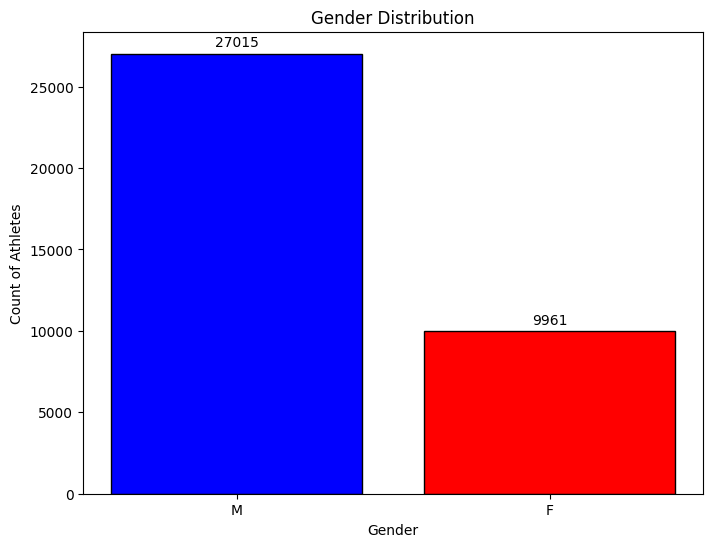

In [262]:
# Get the count of each gender
gender_counts = CFOpenAthletesStats_df['Gender'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'red'], edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Count of Athletes')
plt.title('Gender Distribution')

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')


plt.show()

Out of a total of 36,976 athletes, there were 73.1% male athletes and 26.9% female athletes who participated in the Open.

<Figure size 1200x600 with 0 Axes>

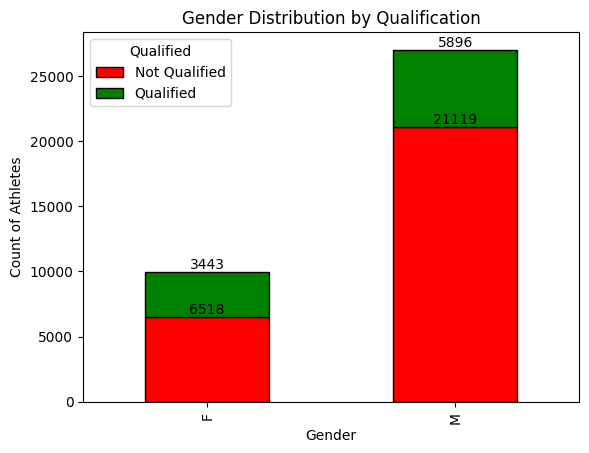

In [263]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a pivot table to count occurrences of each combination
pivot_table = CFOpenAthletesStats_df.pivot_table(index='Gender', columns='QualifiedForQF', aggfunc='size', fill_value=0)

# Define custom colors for each category
colors = {True: 'green', False: 'red'}

# Create a stacked bar chart
plt.figure(figsize=(12, 6))

bars = pivot_table.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_table.columns], edgecolor='black')

plt.xlabel('Gender')
plt.ylabel('Count of Athletes')
plt.title('Gender Distribution by Qualification')

# Add data labels for each bar segment
for container in bars.containers:
    for rect in container.patches:
        width = rect.get_width()
        x_pos = rect.get_x() + width / 2
        y_pos = rect.get_y() + rect.get_height()
        label = int(rect.get_height())  # Use height to get the count
        plt.annotate(label,
                     xy=(x_pos, y_pos),
                     xytext=(0, 0),
                     textcoords="offset points",
                     ha='center', va='bottom', color='black', fontsize=10)

# Add a legend
plt.legend(title='Qualified', labels=['Not Qualified', 'Qualified'], loc='upper left')

plt.show()


For the female athletes, 34.6% qualified for the QuarterFinals.
For the male athletes, 21.8% qualified for the QuarterFinals.
However, this chart is not fully representative of the reality as the rule for QuarterFinals qualification is the top 10% of all participants.

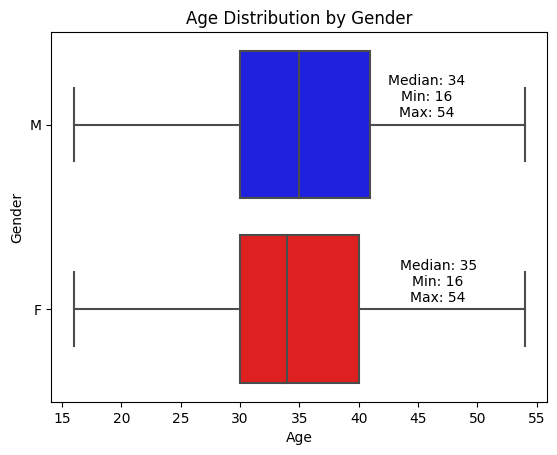

In [264]:
# Create a custom color palette
custom_palette = {"F": "red", "M": "blue"}

ax = sns.boxplot(x='Age', y='Gender', data=CFOpenAthletesStats_df, palette=custom_palette)

# Calculate and add labels for median, min, and max values
medians = CFOpenAthletesStats_df.groupby(['Gender'])['Age'].median().values
mins = CFOpenAthletesStats_df.groupby(['Gender'])['Age'].min().values
maxs = CFOpenAthletesStats_df.groupby(['Gender'])['Age'].max().values

median_labels = [str(int(np.round(median))) for median in medians]
min_labels = [str(int(min_val)) for min_val in mins]
max_labels = [str(int(max_val)) for max_val in maxs]

# Add text annotations to the plot
pos = range(len(medians))
for tick in pos:
    ax.annotate(f'Median: {median_labels[tick]}\nMin: {min_labels[tick]}\nMax: {max_labels[tick]}',
                xy=(medians[tick], tick), xytext=(100, 20), textcoords='offset points',
                horizontalalignment='center', verticalalignment='center',
                size='medium', color='black')

plt.xlabel('Age')
plt.ylabel('Gender')
plt.title('Age Distribution by Gender')
plt.show()

For both female and male atheltes, the youngest athlete was 16 years old and the oldest athlete was 54 years old. The median age is 35 and 34 years old respectively.

This is an interesting statistics, because it shows that this sport is geared towards people who are in their late 20s and their 30s.

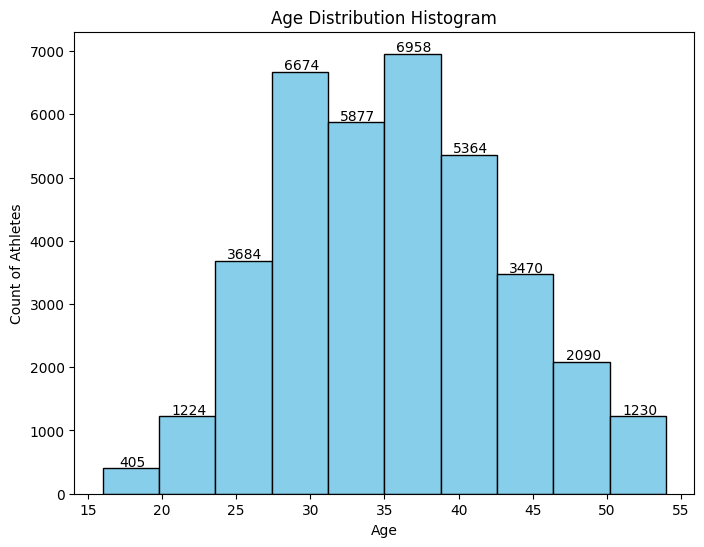

In [265]:
plt.figure(figsize=(8, 6))

# Create a histogram
n, bins, patches = plt.hist(CFOpenAthletesStats_df['Age'], bins=10, color='skyblue', edgecolor='black') 

plt.xlabel('Age')
plt.ylabel('Count of Athletes')
plt.title('Age Distribution Histogram')

# Annotate each bin with its count
for count, x in zip(n, bins):
    plt.annotate(str(int(count)), xy=(x+ 2, count+ 30), ha='center', fontsize=10, color='black')


plt.show()

67.2% of the athletes are aged between 27 and 43. As stated above, it seems that people are well in their late 20s or in their 30s mostly. It could be the fact that CrossFit is an expensive sport and has a high financial entry barrier. People who could afford to do CrossFit would therefore not be younger people. The older participants could be doing so to maintain their physical health.

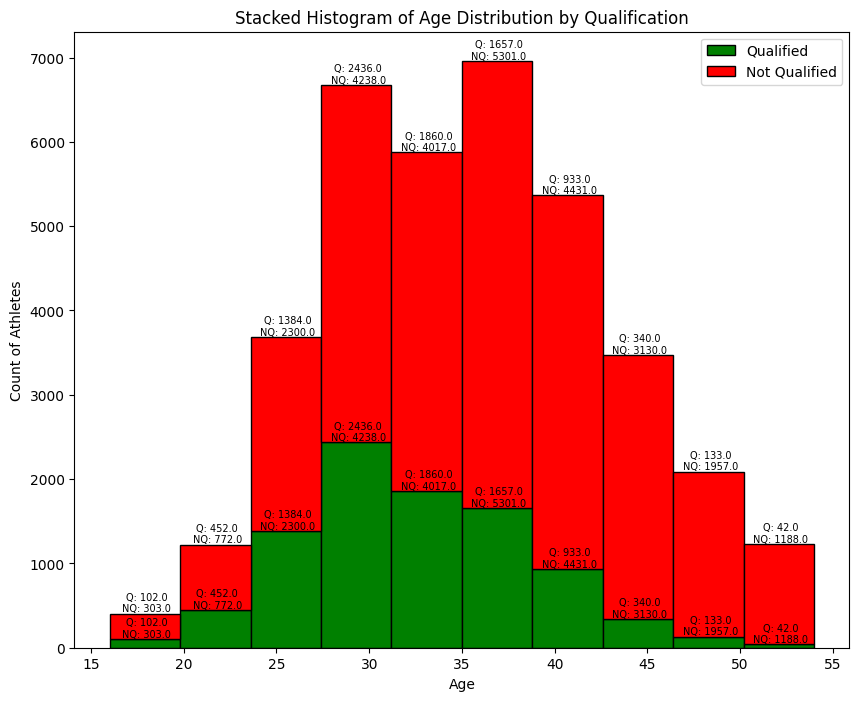

In [266]:
plt.figure(figsize=(10, 8))

# Create separate DataFrames for qualified and not qualified athletes
qualified_data = CFOpenAthletesStats_df[CFOpenAthletesStats_df['QualifiedForQF'] == True]
not_qualified_data = CFOpenAthletesStats_df[CFOpenAthletesStats_df['QualifiedForQF'] == False]

# Create a histogram
hist = plt.hist([qualified_data['Age'], not_qualified_data['Age']], bins=10, color=['green', 'red'], edgecolor='black',label=['Qualified', 'Not Qualified'], stacked=True) 

plt.xlabel('Age')
plt.ylabel('Count of Athletes')
plt.title('Stacked Histogram of Age Distribution by Qualification')

# Annotate each bin with its count
for i in range(len(hist[0][0])):
    total_height = hist[0][0][i] + hist[0][1][i]
    for j, count in enumerate([hist[0][0][i], hist[0][1][i]]):
        plt.text(hist[1][i] + 2, total_height + 20 - count,
                 f'Q: {hist[0][0][i]}\nNQ: {hist[0][1][i]-hist[0][0][i]}',
                 ha='center', fontsize=7)
plt.legend()
plt.show()

In this chart, it shows in which age range the top performers are. People in their mid to late 20s and and in their 30s are those mainly qualified to QuarterFinals.

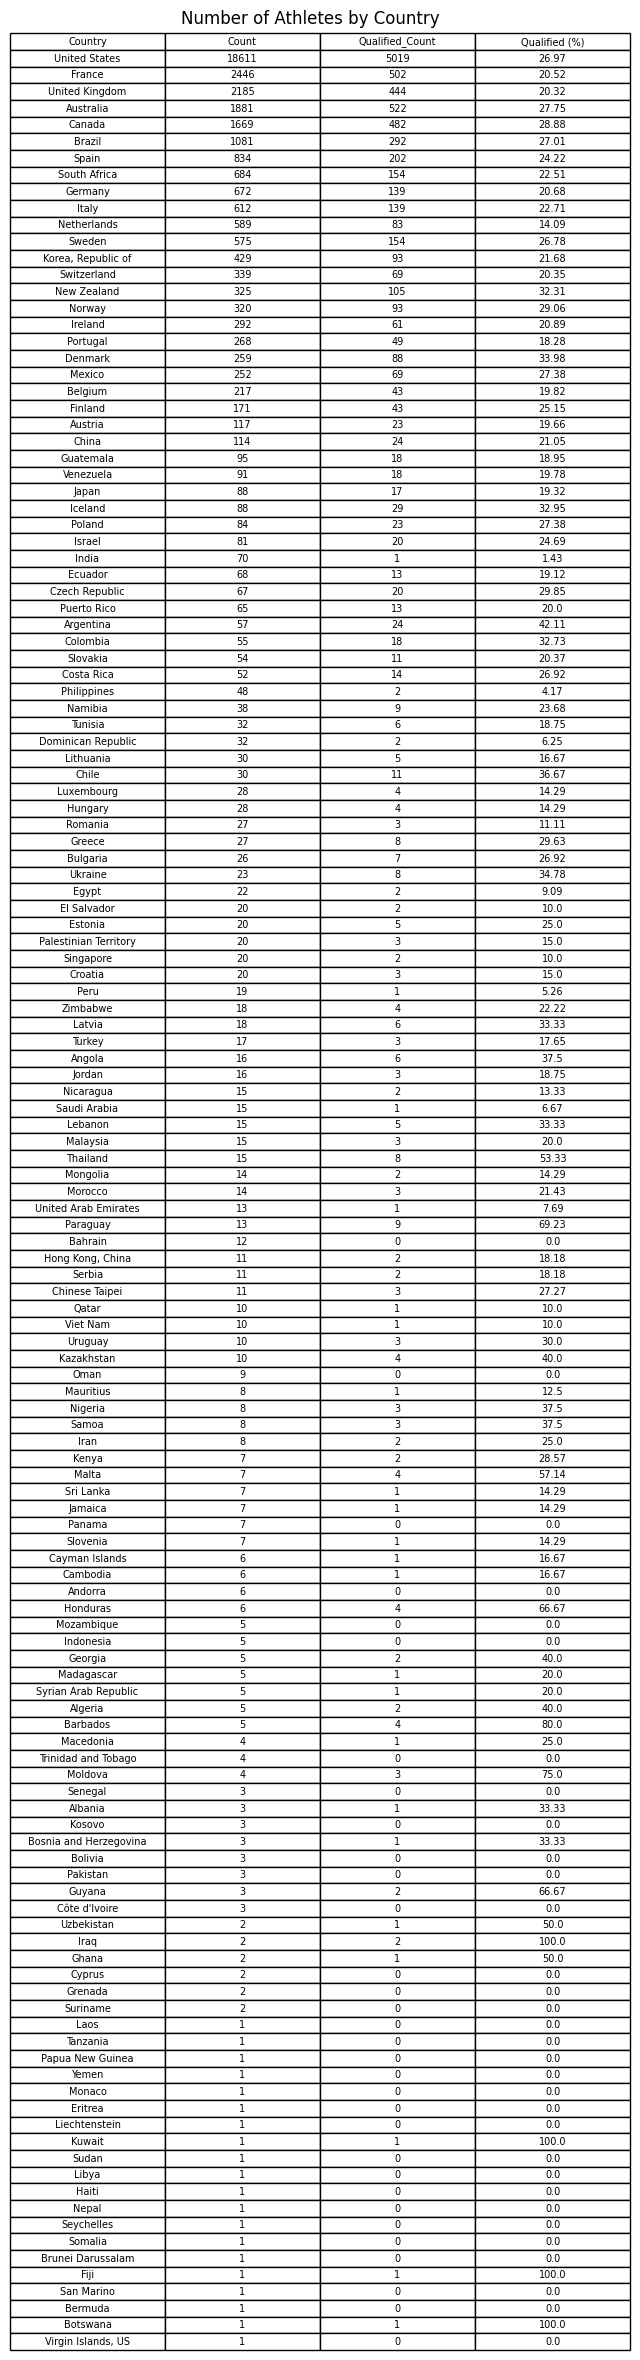

In [267]:
# Get the count of each gender
country_counts = CFOpenAthletesStats_df['CountryOfOriginName'].value_counts()
country_qualify_counts = qualified_data['CountryOfOriginName'].value_counts()
country_data = pd.concat([country_counts, country_qualify_counts], axis=1, keys=['Count', 'Qualify_Count'])
country_data = country_data.fillna(0).astype(int)
country_data['Qualify_Percentage'] = round((country_data['Qualify_Count'] / country_data['Count']) * 100,2)


# Create a table
plt.figure(figsize=(8, 4))
ax = plt.gca()

# Convert the index to a column ('Country')
country_data.reset_index(inplace=True)

# Create the table with combined data
ax.table(cellText=country_data.values, loc='center', cellLoc='center', colLabels=['Country', 'Count', 'Qualified_Count','Qualified (%)'])
# Hide the axis
ax.axis('off')  

plt.suptitle('Number of Athletes by Country', y=3.45)

plt.show()



Based on this table, we can see that CrossFit is US dominant sport based on the number of participants and also the number of athletes who qualified.

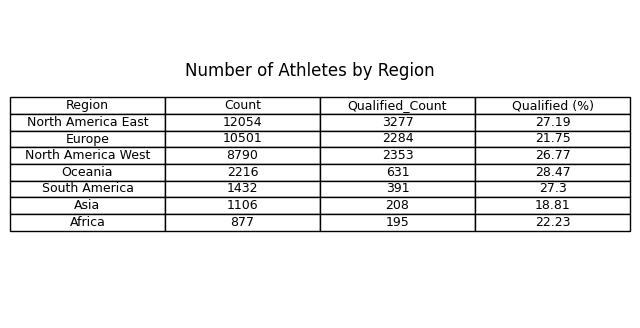

In [268]:
# Get the count of each gender
region_counts = CFOpenAthletesStats_df['RegionName'].value_counts()
region_qualify_counts = qualified_data['RegionName'].value_counts()
region_data = pd.concat([region_counts, region_qualify_counts], axis=1, keys=['Count', 'Qualify_Count'])
region_data = region_data.fillna(0).astype(int)
region_data['Qualify_Percentage'] = round((region_data['Qualify_Count'] / region_data['Count']) * 100,2)

# Create a table
plt.figure(figsize=(8, 4))
ax = plt.gca()

# Hide the axis
ax.axis('off')  
ax.table(cellText=region_data.reset_index().values, loc='center', cellLoc='center', colLabels=['Region', 'Count','Qualified_Count','Qualified (%)'])

plt.suptitle('Number of Athletes by Region', y=0.75)

plt.show()

Simlarly, we can see how North America is dominant in terms of participation. CrossFit in Europe is also quite popular.

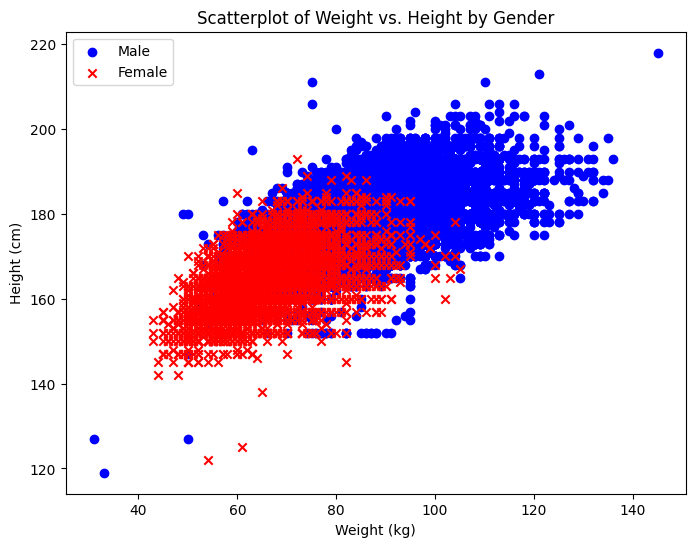

In [269]:
# Separate the data by gender
male_data = CFOpenAthletesStats_df[CFOpenAthletesStats_df['Gender'] == 'M']
female_data = CFOpenAthletesStats_df[CFOpenAthletesStats_df['Gender'] == 'F']

plt.figure(figsize=(8, 6))

# Create a scatterplot for male data
plt.scatter(male_data['WeightInKg'], male_data['HeightInCm'], label='Male', color='blue', marker='o')

# Create a scatterplot for female data
plt.scatter(female_data['WeightInKg'], female_data['HeightInCm'], label='Female', color='red', marker='x')

plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.title('Scatterplot of Weight vs. Height by Gender')

plt.legend()

plt.show()

This scatterplot helps to see the relationship between weight and height of athletes. This allows us to see what's the average physique of a CrossFit athlete.

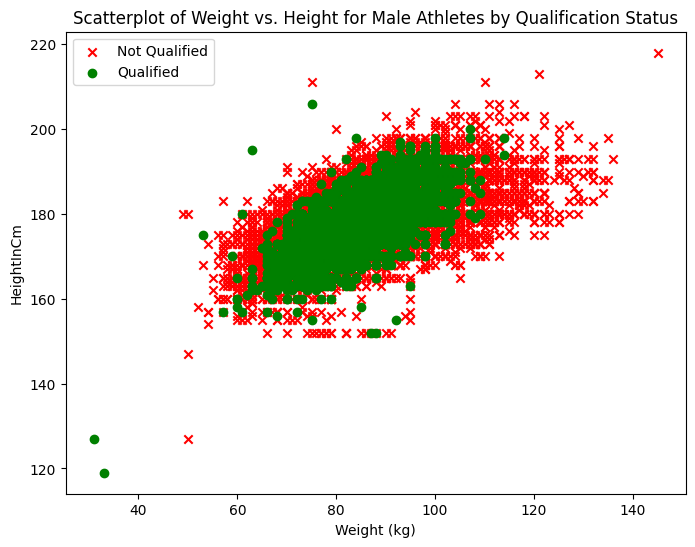

In [270]:
# Separate the data for male
maleQ_data = CFOpenAthletesStats_df[(CFOpenAthletesStats_df['Gender'] == 'M') & (CFOpenAthletesStats_df['QualifiedForQF'] == True)]
maleNQ_data = CFOpenAthletesStats_df[(CFOpenAthletesStats_df['Gender'] == 'M') & (CFOpenAthletesStats_df['QualifiedForQF'] == False)]

plt.figure(figsize=(8, 6))

# Create a scatterplot for male data
plt.scatter(maleNQ_data['WeightInKg'], maleNQ_data['HeightInCm'], label='Not Qualified', color='red', marker='x')
plt.scatter(maleQ_data['WeightInKg'], maleQ_data['HeightInCm'], label='Qualified', color='green', marker='o')

plt.xlabel('Weight (kg)')
plt.ylabel('HeightInCm')
plt.title('Scatterplot of Weight vs. Height for Male Athletes by Qualification Status')

plt.legend()
plt.show()

For male athletes, the ideal physique to qualify for QuarterFinals would be around 175cm and 85kg. As we can see at the bottom left, there is also some data quality issues.

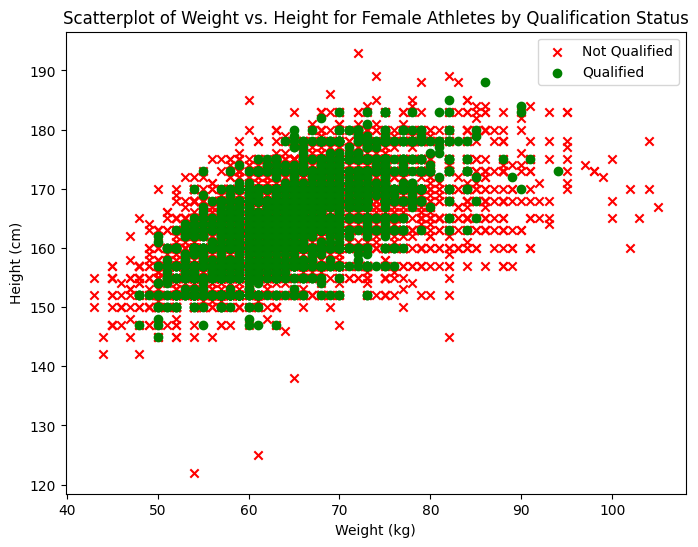

In [271]:
# Separate the data for female
femaleQ_data = CFOpenAthletesStats_df[(CFOpenAthletesStats_df['Gender'] == 'F') & (CFOpenAthletesStats_df['QualifiedForQF'] == True)]
femaleNQ_data = CFOpenAthletesStats_df[(CFOpenAthletesStats_df['Gender'] == 'F') & (CFOpenAthletesStats_df['QualifiedForQF'] == False)]

plt.figure(figsize=(8, 6))

# Create a scatterplot for female data
plt.scatter(femaleNQ_data['WeightInKg'], femaleNQ_data['HeightInCm'], label='Not Qualified', color='red', marker='x')
plt.scatter(femaleQ_data['WeightInKg'], femaleQ_data['HeightInCm'], label='Qualified', color='green', marker='o')

plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.title('Scatterplot of Weight vs. Height for Female Athletes by Qualification Status')

plt.legend()
plt.show()

Similarly, for the females, the ideal physique to qualify for the QuarterFinals would be 165cm and 63kg.

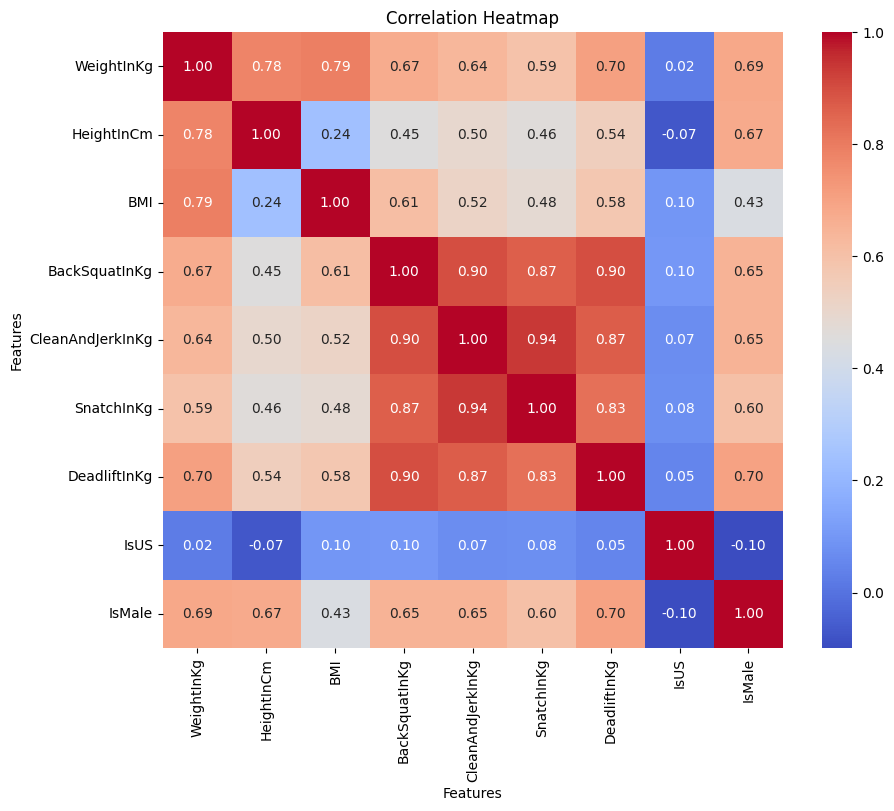

In [300]:
# Select columns for correlation matrix
selected_columns = CFOpenAthletesStats_df[['WeightInKg', 'HeightInCm', 'BMI','BackSquatInKg','CleanAndJerkInKg','SnatchInKg','DeadliftInKg','IsUS','IsMale']]

# Compute the correlation matrix
correlation_matrix = selected_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

These are the main predictor variables that we will using for our analysis. There are three key observations here. 

First is related to the athlete's physique and gender. Weight is strongly correlated to height and the BMI index. This also translates to the weights they can lift. Being a male is also correlated to a higher values in weight, height and lifts.

Second is related to the lifts. They are strongly correlated to each other, which could be an issue for the regression analysis as this is a sign of multicollinearity and could undermine the statistical significant of the predictors.

Lastly, since CrossFit is dominant in the US, because it originated from there, we want to see if being from the US helps in athlete's training. Because there are more resources and potentially better coaching, do US-based athletes have an edge in terms of performance? As we can see from the heat map, there is no correlation. Therefore, we can safely assume that the Country and Region are not relevant variables.

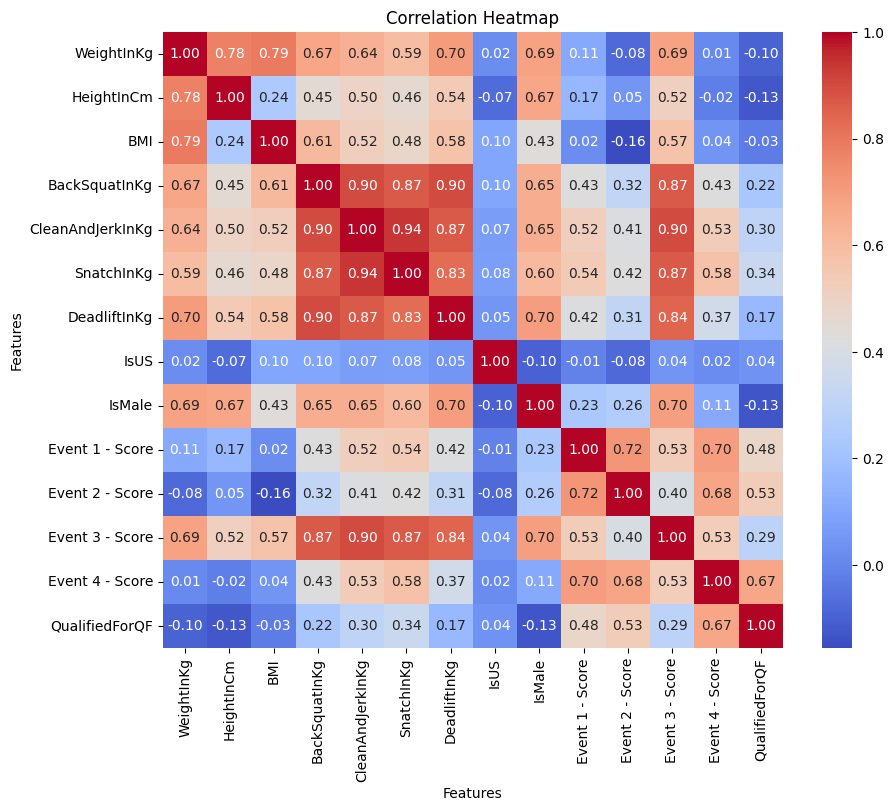

In [301]:
# Select columns for correlation matrix
selected_columns = CFOpenAthletesStats_df[['WeightInKg', 'HeightInCm', 'BMI','BackSquatInKg','CleanAndJerkInKg','SnatchInKg','DeadliftInKg','IsUS','IsMale','Event 1 - Score','Event 2 - Score','Event 3 - Score','Event 4 - Score','QualifiedForQF']]

# Compute the correlation matrix
correlation_matrix = selected_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

We now expand our correlation matrix to the scoring and their qualification. Other than Event 3, which is a lift event, there are no strong correlation from an athlete's physique and their benchmark scores to the events scoring and whether they qualify or not.

# Objective 1 - Regression Analysis to Evaluate Predictor Varaibles and their Impact on Event Scores

In order to answer the requirements of the objective #1, this section will dive deeper into the correlation between an athlete's physique and benchmark scores to the performance scores at the events. This will serve as evidence for the interpretation of the above correlation matrix.

As a reminder, Objectvie #1 is as follows:

Based on the Open 2023, we will evaluate the athletes’ profile, such as their age, height, weight, gender and their benchmark scores (if entered in their profile) to determine how well they would have performed at each test in 2023. We will use regression to understand how each variable of an athlete’s profile would impact their scores.

In [5]:
event_reg_df = CFOpenAthletesStats_df

event_reg_df = event_reg_df[['Gender','Age','CountryOfOriginName','RegionName','Event 1 - Rank','Event 1 - Score',
                             'Event 2 - Rank','Event 2 - Score','Event 3 - Rank','Event 3 - Score', 'Event 4 - Rank','Event 4 - Score',
                             'HeightInCm','WeightInKg','BMI','QualifiedForQF','BackSquatInKg','CleanAndJerkInKg','SnatchInKg','DeadliftInKg','IsUS','IsMale']]

event_reg_df

,Gender,Age,CountryOfOriginName,RegionName,Event 1 - Rank,Event 1 - Score,Event 2 - Rank,Event 2 - Score,Event 3 - Rank,Event 3 - Score,...,HeightInCm,WeightInKg,BMI,QualifiedForQF,BackSquatInKg,CleanAndJerkInKg,SnatchInKg,DeadliftInKg,IsUS,IsMale
0,M,29,Canada,North America East,6,298,37,181,59,312,...,175,89,29.1,True,215,171,132,257,0,1
1,M,27,United States,North America East,64,277,144,175,10,327,...,183,96,28.7,True,227,177,154,279,1,1
2,M,25,United States,North America West,88,274,49,180,174,302,...,163,82,30.9,True,252,152,125,247,1,1
3,M,23,Mexico,North America West,104,273,359,170,27,317,...,170,86,29.8,True,202,159,127,234,0,1
4,M,27,Canada,North America East,16,292,261,172,340,295,...,180,93,28.7,True,197,168,138,240,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36971,F,30,Sweden,Europe,69447,69,78803,20,78272,77,...,174,88,29.1,False,50,49,30,115,0,0
36972,F,36,United States,North America West,70183,60,78953,15,79007,65,...,165,70,25.7,False,66,50,39,93,1,0
36973,F,32,United States,North America East,71153,1,79107,1,79159,35,...,168,73,25.9,False,154,91,63,175,1,0
36974,F,34,United States,North America East,71153,1,79107,1,79172,33,...,172,65,22.0,False,130,100,83,125,1,0


## Event 1 

|Method  |Description   |Selected?| 
|---|---|---|
|Linear Regression| It is considerd the baseline model for continuous target variable. It uses linear relationship between the predictors and the target.|   |
|Polynomial Degree 2|It is an extension of the linear regression as it captures complex, non-linear relationships.|   |
|Polynomial Degree 3|It is an extension of the linear regression as it captures complex, non-linear relationships.|   |
|Elastic Net Model (Original Data)|Elastic Net combines Lasso and Ridge regularization with linear regression. It addresses multicollinearity and overfitting issues.|   |
|Elastic Net Model (Polynomial Degree 3 Transformed Data)|Elastic Net combines Lasso and Ridge regularization with linear regression. It addresses multicollinearity and overfitting issues.| |
|Support Vector Regression - GridSearch|SVR is a useful method for predicting continuous values with the use of hyperplane that best fits the data while minimizing the margin of error. SVR is useful to capture complex nonlinear patterns in data. GridSearch allows to optimize the hyperparameters of SVR.|   |

We will first do an analysis on the male athletes for Event 1 as a preliminary analysis.

In [13]:
male_event1_reg_df = event_reg_df[event_reg_df['IsMale']==1]

In [14]:
X_male_event1 = male_event1_reg_df.drop(['Gender','CountryOfOriginName','RegionName','Event 1 - Rank','Event 1 - Score',
                                         'Event 2 - Rank','Event 2 - Score','Event 3 - Rank','Event 3 - Score',
                                         'Event 4 - Rank','Event 4 - Score','QualifiedForQF','IsMale'],axis = 1)
Y_male_event1 = male_event1_reg_df['Event 1 - Score']

### Linear Regression

In [11]:
X_male_event1_const = sm.add_constant(X_male_event1)

sm.OLS(Y_male_event1,X_male_event1_const).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 1 - Score   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     1865.
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:25:32   Log-Likelihood:            -1.1311e+05
No. Observations:               27015   AIC:                         2.262e+05
Df Residuals:                   27005   BIC:                         2.263e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -50.9755     24.446     -2.085      0.037     -98.891      -3.060
Age                 -0.1621      0.014    -11.870      0.000      -0.189      -0.135
HeightInCm           1.3008      0.137      9.481      0.000       1.032       1.570
WeightInKg          -1.6206      0.143    -11.335      0.000      -1.901      -1.340
BMI                  2.8638      0.455      6.291      0.000       1.972       3.756
BackSquatInKg       -0.0276      0.007     -3.829      0.000      -0.042      -0.013
CleanAndJerkInKg     0.2608      0.012     21.443      0.000       0.237       0.285
SnatchInKg           0.3739      0.012     30.518      0.000       0.350       0.398
DeadliftInKg         0.0642      0.006     11.148      0.000       0.053       0.075
IsUS                -2.8071      0.203    -13.860      0.000      -3.204      -2.410
==============================================================================
Omnibus:                    10692.302   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           344344.978
Skew:                          -1.271   Prob(JB):                         0.00
Kurtosis:                      20.305   Cond. No.                     8.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Polynomial Regression Degree 2

In [38]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_male_event1_poly2 = poly.fit_transform(X_male_event1)
X_male_event1_poly2_const = sm.add_constant(X_male_event1_poly2)

In [276]:
sm.OLS(Y_male_event1,X_male_event1_poly2_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 1 - Score   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     356.3
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:38:08   Log-Likelihood:            -1.1246e+05
No. Observations:               27015   AIC:                         2.250e+05
Df Residuals:                   26961   BIC:                         2.255e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7059.0123   1082.218      6.523      0.000    4937.809    9180.216
x1            -2.7516      3.241     -0.849      0.396      -9.104       3.601
x2           -79.8398     12.325     -6.478      0.000    -103.997     -55.683
x3            93.8371     13.493      6.954      0.000      67.390     120.284
x4          -273.9405     41.050     -6.673      0.000    -354.400    -193.481
x5            -4.6120      1.672     -2.758      0.006      -7.890      -1.334
x6             6.2405      3.006      2.076      0.038       0.349      12.132
x7            -2.1856      3.026     -0.722      0.470      -8.116       3.745
x8             1.7235      1.411      1.221      0.222      -1.043       4.490
x9             6.9008     25.711      0.268      0.788     -43.494      57.296
x10           -0.0048      0.001     -3.248      0.001      -0.008      -0.002
x11            0.0168      0.018      0.923      0.356      -0.019       0.052
x12           -0.0125      0.019     -0.653      0.513      -0.050       0.025
x13            0.0600      0.061      0.981      0.327      -0.060       0.180
x14            0.0012      0.001      1.169      0.242      -0.001       0.003
x15            0.0033      0.002      1.938      0.053   -3.63e-05       0.007
x16           -0.0147      0.002     -8.563      0.000      -0.018      -0.011
x17            0.0001      0.001      0.137      0.891      -0.001       0.002
x18            0.0391      0.028      1.408      0.159      -0.015       0.094
x19            0.2275      0.035      6.449      0.000       0.158       0.297
x20           -0.5172      0.077     -6.743      0.000      -0.668      -0.367
x21            1.5571      0.236      6.600      0.000       1.095       2.020
x22            0.0266      0.009      2.837      0.005       0.008       0.045
x23           -0.0388      0.017     -2.300      0.021      -0.072      -0.006
x24            0.0151      0.017      0.893      0.372      -0.018       0.048
x25           -0.0095      0.008     -1.196      0.232      -0.025       0.006
x26           -0.0493      0.289     -0.171      0.864      -0.615       0.516
x27            0.2804      0.041      6.780      0.000       0.199       0.362
x28           -1.7970      0.252     -7.122      0.000      -2.292      -1.302
x29           -0.0267      0.010     -2.791      0.005      -0.046      -0.008
x30            0.0407      0.017      2.346      0.019       0.007       0.075
x31           -0.0190      0.017     -1.085      0.278      -0.053       0.015
x32            0.0071      0.008      0.872      0.383      -0.009       0.023
x33            0.0975      0.300      0.325      0.746      -0.491       0.686
x34            2.6175      0.388      6.744      0.000       1.857       3.378
x35            0.0827      0.030      2.718      0.007       0.023       0.142
x3

### Polynomial Regression Degree 3

In [37]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_male_event1_poly3 = poly.fit_transform(X_male_event1)
X_male_event1_poly3_const = sm.add_constant(X_male_event1_poly3)

In [277]:
sm.OLS(Y_male_event1,X_male_event1_poly3_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 1 - Score   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     97.23
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:38:13   Log-Likelihood:            -1.1204e+05
No. Observations:               27015   AIC:                         2.245e+05
Df Residuals:                   26806   BIC:                         2.262e+05
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.497e+05   8.81e+04      2.835      0.005    7.71e+04    4.22e+05
x1          -418.7885    297.083     -1.410      0.159   -1001.087     163.510
x2         -3973.6093   1485.977     -2.674      0.007   -6886.202   -1061.017
x3          4281.5433   1652.299      2.591      0.010    1042.951    7520.135
x4         -1.395e+04   5089.976     -2.740      0.006   -2.39e+04   -3970.735
x5           290.7044    166.300      1.748      0.080     -35.253     616.662
x6          -942.6038    330.969     -2.848      0.004   -1591.319    -293.888
x7            99.1081    320.577      0.309      0.757    -529.240     727.456
x8           153.7760    148.683      1.034      0.301    -137.651     445.203
x9         -1521.7314   1621.569     -0.938      0.348   -4700.092    1656.629
x10            0.2502      0.370      0.677      0.499      -0.475       0.975
x11            4.3588      3.346      1.303      0.193      -2.199      10.916
x12           -4.4634      3.463     -1.289      0.197     -11.251       2.324
x13           15.2899     10.994      1.391      0.164      -6.258      36.838
x14           -0.2343      0.240     -0.975      0.330      -0.705       0.237
x15            0.8334      0.445      1.874      0.061      -0.038       1.705
x16           -0.0748      0.472     -0.158      0.874      -1.000       0.851
x17           -0.1677      0.210     -0.797      0.425      -0.580       0.245
x18           -3.9265      3.639     -1.079      0.281     -11.060       3.207
x19           21.0055      8.369      2.510      0.012       4.601      37.410
x20          -45.9073     18.479     -2.484      0.013     -82.127      -9.688
x21          149.6933     58.512      2.558      0.011      35.006     264.381
x22           -3.3324      1.869     -1.783      0.075      -6.996       0.331
x23           10.5528      3.721      2.836      0.005       3.259      17.846
x24           -0.8969      3.625     -0.247      0.805      -8.002       6.208
x25           -1.7006      1.673     -1.017      0.309      -4.979       1.578
x26           24.8796     27.359      0.909      0.363     -28.745      78.504
x27           24.3007     10.132      2.399      0.016       4.442      44.159
x28         -155.4955     61.334     -2.535      0.011    -275.713     -35.278
x29            2.9056      1.857      1.565      0.118      -0.733       6.545
x30          -10.3808      3.696     -2.808      0.005     -17.626      -3.135
x31            1.1833      3.601      0.329      0.742      -5.874       8.241
x32            1.6261      1.667      0.976      0.329      -1.641       4.893
x33          -26.2715     27.824     -0.944      0.345     -80.807      28.264
x34          252.9961     95.302      2.655      0.008      66.199     439.793
x35           -9.8899      5.790     -1.708      0.088     -21.238       1.458
x3

### Elastic Net Model - GridSearch (Using Original Data)

Best Alpha: 0.001
Best L1 Ratio: 1.0
Root Mean Squared Error (RMSE): 15.587977032574994
R-squared: 0.3870231275398909


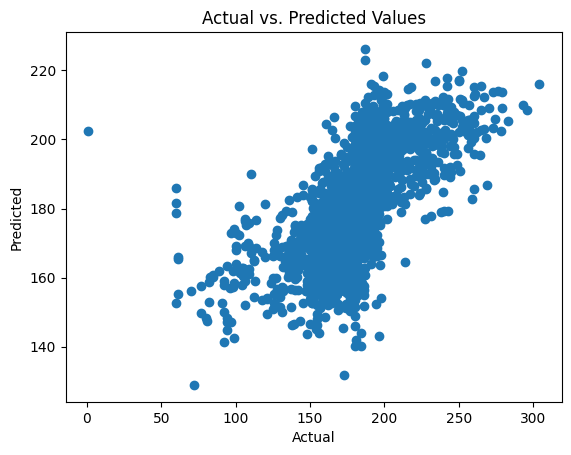

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_male_event1, Y_male_event1, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Elastic Net model
elastic_net = ElasticNet()

# Define a grid of alpha values to search
alphas = [0.001, 0.01, 0.1, 1.0]
ratios = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Create a parameter grid for GridSearchCV
param_grid = {'alpha': alphas,'l1_ratio':ratios}

# Define a scoring metric (e.g., Mean Squared Error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']
best_ratio = grid_search.best_params_['l1_ratio']

print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_ratio)

# Create and train the final Elastic Net model with the best alpha
final_elastic_net = ElasticNet(alpha=best_alpha,l1_ratio=best_ratio)
final_elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = final_elastic_net.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Elastic Net Model - GridSearch (Using Polynomial Degree 3 Transformed Data)

Best Alpha: 0.001
Best L1 Ratio: 0.0
Root Mean Squared Error (RMSE): 15.265965826615991
R-squared: 0.412086887970997


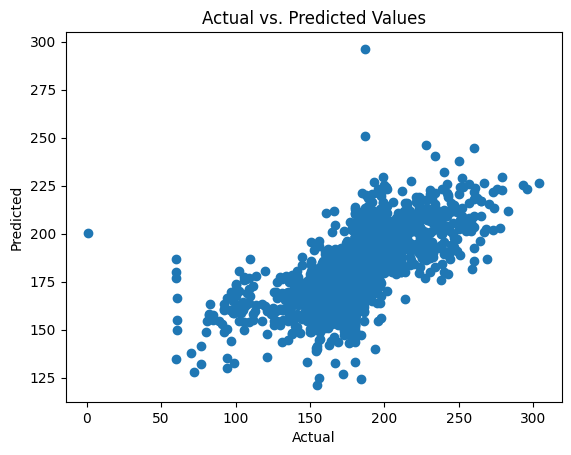

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_male_event1_poly3, Y_male_event1, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Elastic Net model
elastic_net = ElasticNet()

# Define a grid of alpha values to search
alphas = [0.001, 0.01, 0.1, 1.0]
ratios = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Create a parameter grid for GridSearchCV
param_grid = {'alpha': alphas,'l1_ratio':ratios}

# Define a scoring metric (e.g., Mean Squared Error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']
best_ratio = grid_search.best_params_['l1_ratio']

print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_ratio)

# Create and train the final Elastic Net model with the best alpha
final_elastic_net = ElasticNet(alpha=best_alpha,l1_ratio=best_ratio)
final_elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = final_elastic_net.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Support Vector Regression (SVR) - Testing

This is to test the different hyperparameters and understand the impact on prediction. Testing with PCA to reduce processing time leads to poorer r-square. Therefore, we will not keep PCA to reduce dimensionality. Furthermore, given that we have not an extensive list of features, dimensionality reduction is not an appropriate approach.

Root Mean Squared Error (RMSE): 16.73291722181241
R-squared: 0.29366959792418634


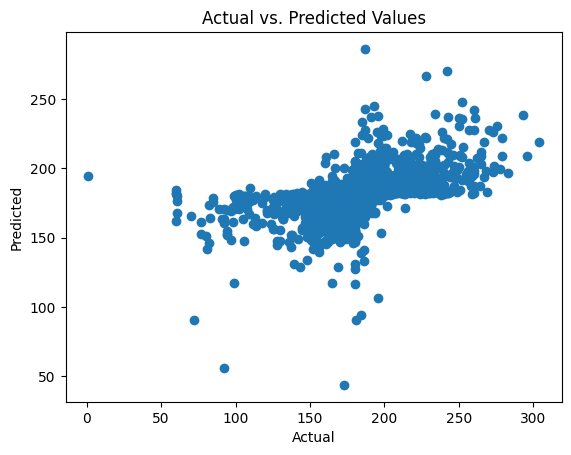

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_male_event1, Y_male_event1, test_size=0.2, random_state=42)


# Reduce Dimensionality with PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Standardize/normalize features
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Create and train the SVR model

# For RBF, higher values of gamma make the kernel more sensitive to individual data points. However, running rbf showed poor r-square despite a low RMSE.

# For Poly, default value of degree is 3, capturing cubic relationships.

# A smaller C value allows for a wider margin but may tolerate more margin violations.
# A larger C value enforces a narrower margin, which may lead to fewer margin violations but could overfit the data.

# A smaller epsilon value results in a narrower tube, making the model less tolerant of prediction errors.
# A larger epsilon value creates a wider tube, allowing for greater flexibility and tolerance to errors.

svr = SVR(kernel='poly', degree=3, C=10, epsilon=0.5)
svr.fit(X_train_pca, y_train)

# Make predictions
y_pred = svr.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

### Support Vector Regression (SVR) - GridSearch

SVR is a useful method for predicting continuous values. In this case, it is applicable as we are trying to predict the event scores. As we saw previously, it seems that the predictor variables perform better in polynomial regression, which indicates a non-linear relationship between the predictors and the target. SVR is useful to capture complex nonlinear patterns in data. We also saw that there are some outlier data as all information on the athletes are entered manually by them. SVR helps dealing with outliers as it concentrates on the data closer to the support vector.

Best Kernel: linear
Best C: 1
Best Epsilon: 0.01
Root Mean Squared Error (RMSE): 15.917447666296
R-squared: 0.36083728065625864


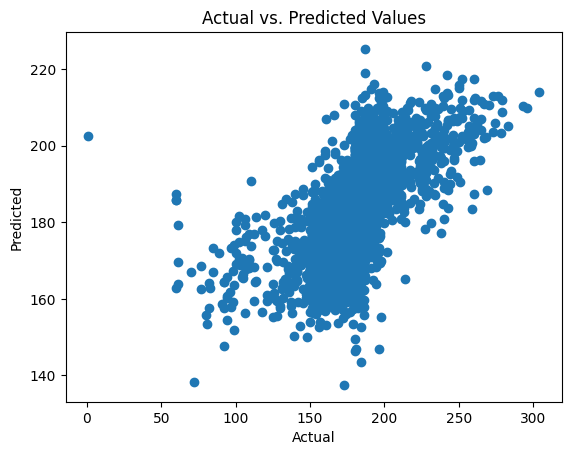

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_male_event1, Y_male_event1, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVR model
svr = SVR(kernel='linear')

# For Poly, default value of degree is 3, capturing cubic relationships.

# A smaller C value allows for a wider margin but may tolerate more margin violations.
# A larger C value enforces a narrower margin, which may lead to fewer margin violations but could overfit the data.

# A smaller epsilon value results in a narrower tube, making the model less tolerant of prediction errors.
# A larger epsilon value creates a wider tube, allowing for greater flexibility and tolerance to errors.


# Define a grid of hyperparameter values to search
param_grid = {
    'kernel': ['linear', 'poly'],  # Different kernel functions
    'C': [0.1, 1, 10],              # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5]    # Margin width
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']
best_epsilon = best_params['epsilon']

print("Best Kernel:", best_kernel)
print("Best C:", best_C)
print("Best Epsilon:", best_epsilon)

# Create and train the SVR model with the best hyperparameters
best_svr = SVR(kernel=best_kernel, C=best_C, epsilon=best_epsilon)
best_svr.fit(X_train, y_train)

# Make predictions
y_pred = best_svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


## Thoughts on Event 1

As a first regression iteration, although the predictor variables are statistically significant,which suggests that they have impact on the target variable, the linear and polynomial regression return low r-square and high AIC and BIC. This indicates that the model is not a right fit for the data due to to model complexity, overfitting or missing important predictor varaibles. When comparing to each other, the AIC and BIC are similar, thus no significant improvement with the data transformation. In this case, it is fair to assume that we simply do not have enough information on the athletes. Therefore, linear and polynomial regression models will not be considered to understand how the predictor variables affect the target variable.

We then used Elastic Net Regression which is a linear regression model that combines both Lasso and Ridge regularization techniques. Some benchmark exercises are correlated to each other. Therefore, this approach allows us to handle correlated predictors while still selecting the best features for the prediction of the target variable. We apply gridsearch to find the optimal parameters for the alpha and l1_ratio for the elastic net model. The alpha is a hyperparameter to determine the overall strength of regularization applied to the model. It determines the balance between the L1 (Lasso) and L2 (Ridge) regularization penalties. In the other hand, the l1_ratio controls the mix of the two types of regularization penalties applied to the model's coefficients.

However, as we can see with the r-square on both attempts of the elastic net model, it has a poor accuracy. Given that the scores are continuous values, it is likely that the predicted values could be off by a few or many repetitions from the actual values.

As for the SVR, we see no significant improvement. The r-square is similar to the other models. When comparing the RMSE of the SVR to the other Elastic Net models, it is also similar. We can interpret models with a low r-square and low RMSE as such: The model's predictions are close to actuals. However, a significant portion of the variance in the target variable cannot be explained by the model. Therefore, the Elastic Net and the SVR are not good models to use as well.

Given that there are several factors that could affect the performance score of an athlete, we would avoid finding a correlation between the currently available predictor variables and the target variable (Event Scores). It is likely that the current predictors are simply not enough for predicting the scores.

However, as shown in the correlation matrix, the only event where we might have valuable insights through regression is in Event 3.


## Event 3

Event 3 is a 1 rep-max thruster. As shown in the correlation matrix, it is closely related to the lifts. A thruster is a similar movement to the clean and jerk without the pause on the sholders when pushing the weight above the head.

|Method  |Description   |Selected?| 
|---|---|---|
|Linear Regression| It is considerd the baseline model for continuous target variable. It uses linear relationship between the predictors and the target.|   |
|Polynomial Degree 2|It is an extension of the linear regression as it captures complex, non-linear relationships.|   |
|Polynomial Degree 3|It is an extension of the linear regression as it captures complex, non-linear relationships.|   |
|Elastic Net Model (Original Data)|Elastic Net combines Lasso and Ridge regularization with linear regression. It addresses multicollinearity and overfitting issues.|   |
|Elastic Net Model (Polynomial Degree 3 Transformed Data)|Elastic Net combines Lasso and Ridge regularization with linear regression. It addresses multicollinearity and overfitting issues.|✓ |
|Support Vector Regression - GridSearch|SVR is a useful method for predicting continuous values with the use of hyperplane that best fits the data while minimizing the margin of error. SVR is useful to capture complex nonlinear patterns in data. GridSearch allows to optimize the hyperparameters of SVR.|   |

In [26]:
event3_reg_df = event_reg_df

In [27]:
X_event3 = event_reg_df.drop(['Gender','CountryOfOriginName','RegionName','Event 1 - Rank','Event 1 - Score',
                                         'Event 2 - Rank','Event 2 - Score','Event 3 - Rank','Event 3 - Score',
                                         'Event 4 - Rank','Event 4 - Score','QualifiedForQF'],axis = 1)
Y_event3 = event_reg_df['Event 3 - Score']

### Linear Regression

In [28]:
X_event3_const = sm.add_constant(X_event3)

sm.OLS(Y_event3,X_event3_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 3 - Score   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.141e+04
Date:                Sun, 27 Aug 2023   Prob (F-statistic):               0.00
Time:                        00:48:48   Log-Likelihood:            -1.5713e+05
No. Observations:               36976   AIC:                         3.143e+05
Df Residuals:                   36965   BIC:                         3.144e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               61.6407     15.254      4.041      0.000      31.742      91.539
Age                 -0.3401      0.012    -27.483      0.000      -0.364      -0.316
HeightInCm          -0.2451      0.088     -2.795      0.005      -0.417      -0.073
WeightInKg           0.4218      0.095      4.448      0.000       0.236       0.608
BMI                  0.3352      0.291      1.151      0.250      -0.235       0.906
BackSquatInKg        0.2113      0.007     30.093      0.000       0.198       0.225
CleanAndJerkInKg     0.5809      0.012     48.544      0.000       0.557       0.604
SnatchInKg           0.4030      0.012     33.467      0.000       0.379       0.427
DeadliftInKg         0.0464      0.006      8.274      0.000       0.035       0.057
IsUS                -0.1731      0.184     -0.941      0.347      -0.534       0.187
IsMale              15.3104      0.345     44.392      0.000      14.634      15.986
==============================================================================
Omnibus:                    12561.015   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           455253.692
Skew:                          -0.967   Prob(JB):                         0.00
Kurtosis:                      20.081   Cond. No.                     5.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the summary results, we will also drop IsUS and BMI as the p-value is above the threshold value of 0.05 for it to be statistically significant to the model.

In [41]:
X_event3 = event_reg_df.drop(['Gender','CountryOfOriginName','RegionName','Event 1 - Rank','Event 1 - Score',
                                         'Event 2 - Rank','Event 2 - Score','Event 3 - Rank','Event 3 - Score',
                                         'Event 4 - Rank','Event 4 - Score','QualifiedForQF','IsUS','BMI'],axis = 1)
Y_event3 = event_reg_df['Event 3 - Score']

In [292]:
X_event3_const = sm.add_constant(X_event3)

sm.OLS(Y_event3,X_event3_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 3 - Score   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.676e+04
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:58:22   Log-Likelihood:            -1.5713e+05
No. Observations:               36976   AIC:                         3.143e+05
Df Residuals:                   36967   BIC:                         3.144e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               78.9144      2.514     31.388      0.000      73.987      83.842
Age                 -0.3421      0.012    -27.944      0.000      -0.366      -0.318
HeightInCm          -0.3434      0.017    -19.966      0.000      -0.377      -0.310
WeightInKg           0.5293      0.013     39.358      0.000       0.503       0.556
BackSquatInKg        0.2108      0.007     30.129      0.000       0.197       0.225
CleanAndJerkInKg     0.5807      0.012     48.534      0.000       0.557       0.604
SnatchInKg           0.4028      0.012     33.452      0.000       0.379       0.426
DeadliftInKg         0.0466      0.006      8.306      0.000       0.036       0.058
IsMale              15.4791      0.325     47.559      0.000      14.841      16.117
==============================================================================
Omnibus:                    12562.542   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           455127.139
Skew:                          -0.967   Prob(JB):                         0.00
Kurtosis:                      20.078   Cond. No.                     9.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing IsUS and BMI did not impact the model. With an r-square of 0.85 and statistically significant predictor variables. However, with a high AIC and BIC, we would try another approach as it needs refinement.

### Polynomial Regression Degree 2

In [42]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_event3_poly2 = poly.fit_transform(X_event3)
X_event3_poly2_const = sm.add_constant(X_event3_poly2)

In [294]:
sm.OLS(Y_event3,X_event3_poly2_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 3 - Score   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     5142.
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:16:11   Log-Likelihood:            -1.5661e+05
No. Observations:               36976   AIC:                         3.133e+05
Df Residuals:                   36932   BIC:                         3.137e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.9430     42.229      2.248      0.025      12.173     177.713
x1             1.1170      0.354      3.154      0.002       0.423       1.811
x2            -0.8477      0.560     -1.514      0.130      -1.945       0.249
x3            -0.0374      0.363     -0.103      0.918      -0.749       0.674
x4            -0.3522      0.189     -1.859      0.063      -0.723       0.019
x5             1.0134      0.336      3.020      0.003       0.356       1.671
x6             1.5064      0.340      4.435      0.000       0.841       2.172
x7            -0.1679      0.153     -1.098      0.272      -0.468       0.132
x8            40.6280      4.798      8.468      0.000      31.224      50.032
x9            -0.0057      0.001     -4.352      0.000      -0.008      -0.003
x10           -0.0055      0.002     -2.358      0.018      -0.010      -0.001
x11            0.0015      0.002      0.839      0.401      -0.002       0.005
x12           -0.0008      0.001     -0.808      0.419      -0.003       0.001
x13            0.0112      0.002      6.803      0.000       0.008       0.014
x14           -0.0167      0.002     -9.926      0.000      -0.020      -0.013
x15            0.0006      0.001      0.760      0.448      -0.001       0.002
x16           -0.1092      0.044     -2.486      0.013      -0.195      -0.023
x17            0.0013      0.002      0.646      0.519      -0.003       0.005
x18            0.0108      0.003      4.137      0.000       0.006       0.016
x19            0.0042      0.001      3.281      0.001       0.002       0.007
x20           -0.0102      0.002     -4.545      0.000      -0.015      -0.006
x21           -0.0020      0.002     -0.848      0.396      -0.006       0.003
x22            0.0014      0.001      1.347      0.178      -0.001       0.003
x23           -0.4308      0.060     -7.200      0.000      -0.548      -0.314
x24           -0.0115      0.001    -10.116      0.000      -0.014      -0.009
x25           -0.0024      0.001     -2.564      0.010      -0.004      -0.001
x26            0.0097      0.002      6.077      0.000       0.007       0.013
x27         5.584e-05      0.002      0.033      0.974      -0.003       0.003
x28           -0.0030      0.001     -3.771      0.000      -0.004      -0.001
x29            0.5362      0.049     11.016      0.000       0.441       0.632
x30            0.0009      0.000      3.830      0.000       0.000       0.001
x31            0.0004      0.001      0.631      0.528      -0.001       0.002
x32           -0.0021      0.001     -2.696      0.007      -0.004      -0.001
x33           -0.0003      0.000     -0.738      0.461      -0.001       0.000
x34           -0.0670      0.027     -2.492      0.013      -0.120      -0.014
x35            0.0042      0.000     10.497      0.000       0.003       0.005
x3

### Polynomial Regression Degree 3

In [43]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_event3_poly3 = poly.fit_transform(X_event3)
X_event3_poly3_const = sm.add_constant(X_event3_poly3)

In [295]:
sm.OLS(Y_event3,X_event3_poly3_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Event 3 - Score   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:16:45   Log-Likelihood:            -1.5594e+05
No. Observations:               36976   AIC:                         3.122e+05
Df Residuals:                   36820   BIC:                         3.135e+05
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        962.5051    397.347      2.422      0.015     183.694    1741.317
x1           -11.9136      6.118     -1.947      0.052     -23.906       0.078
x2            -7.4843      7.825     -0.957      0.339     -22.821       7.852
x3           -10.2281      5.419     -1.888      0.059     -20.849       0.392
x4            -2.0965      3.258     -0.643      0.520      -8.483       4.290
x5             7.1940      5.959      1.207      0.227      -4.485      18.873
x6           -11.3966      5.819     -1.958      0.050     -22.802       0.009
x7            -0.4437      2.477     -0.179      0.858      -5.299       4.412
x8           210.9588     45.242      4.663      0.000     122.283     299.635
x9             0.0523      0.040      1.318      0.188      -0.025       0.130
x10            0.1412      0.078      1.818      0.069      -0.011       0.293
x11           -0.1154      0.053     -2.195      0.028      -0.218      -0.012
x12            0.0461      0.027      1.694      0.090      -0.007       0.099
x13           -0.0024      0.049     -0.050      0.960      -0.098       0.093
x14           -0.0148      0.050     -0.294      0.769      -0.113       0.084
x15            0.0115      0.023      0.508      0.612      -0.033       0.056
x16           -0.9347      0.644     -1.450      0.147      -2.198       0.328
x17           -0.0317      0.054     -0.590      0.555      -0.137       0.074
x18            0.2558      0.075      3.419      0.001       0.109       0.403
x19           -0.0293      0.042     -0.692      0.489      -0.112       0.054
x20           -0.0623      0.078     -0.804      0.422      -0.214       0.090
x21            0.1693      0.076      2.223      0.026       0.020       0.319
x22            0.0138      0.032      0.427      0.670      -0.050       0.077
x23           -3.2357      0.882     -3.667      0.000      -4.965      -1.506
x24           -0.0776      0.031     -2.541      0.011      -0.137      -0.018
x25            0.0597      0.025      2.348      0.019       0.010       0.110
x26           -0.0452      0.048     -0.949      0.343      -0.138       0.048
x27           -0.0844      0.049     -1.733      0.083      -0.180       0.011
x28           -0.0402      0.021     -1.930      0.054      -0.081       0.001
x29            1.5723      0.684      2.299      0.022       0.232       2.913
x30            0.0146      0.007      2.096      0.036       0.001       0.028
x31           -0.0251      0.021     -1.187      0.235      -0.066       0.016
x32            0.0165      0.022      0.749      0.454      -0.027       0.060
x33            0.0158      0.010      1.593      0.111      -0.004       0.035
x34           -1.7489      0.393     -4.452      0.000      -2.519      -0.979
x35            0.0232      0.016      1.432      0.152      -0.009       0.055
x3

Using polynomial regression, we still observe high AIC and BIC. Hence, we will try to use elastic net to handle the correlated variables.

### Elastic Net Model - GridSearch (Using Original Data)

Best Alpha: 0.001
Best L1 Ratio: 0.5
Root Mean Squared Error (RMSE): 16.39429571568551
R-squared: 0.861838409114738


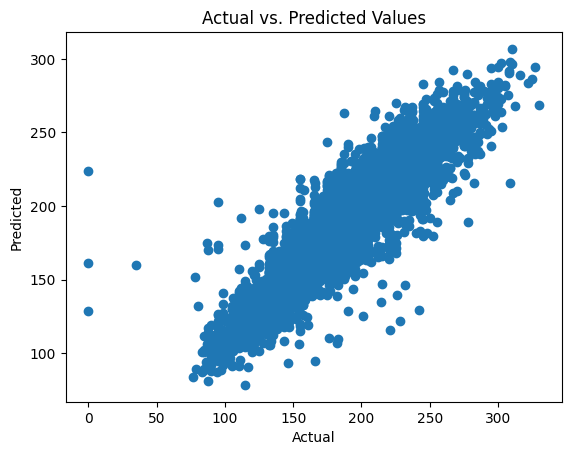

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_event3, Y_event3, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Elastic Net model
elastic_net = ElasticNet()

# Define a grid of alpha values to search
alphas = [0.001, 0.01, 0.1, 1.0]
ratios = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Create a parameter grid for GridSearchCV
param_grid = {'alpha': alphas,'l1_ratio':ratios}

# Define a scoring metric (e.g., Mean Squared Error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']
best_ratio = grid_search.best_params_['l1_ratio']

print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_ratio)

# Create and train the final Elastic Net model with the best alpha
final_elastic_net = ElasticNet(alpha=best_alpha,l1_ratio=best_ratio)
final_elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = final_elastic_net.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Elastic Net Model - GridSearch (Using Polynomial Degree 3 Data)

Best Alpha: 0.001
Best L1 Ratio: 0.6
Root Mean Squared Error (RMSE): 16.218693903139613
R-squared: 0.864782297925616


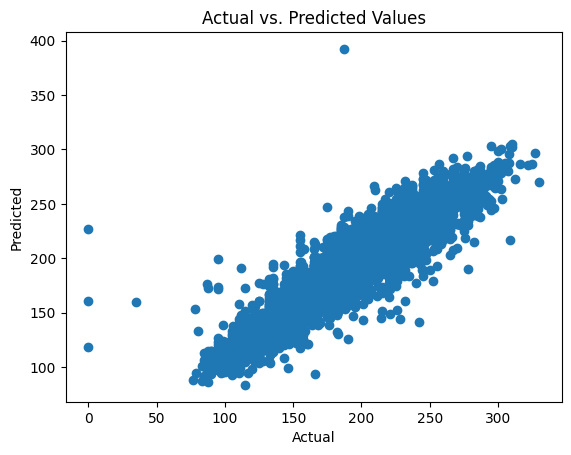

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_event3_poly3, Y_event3, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Elastic Net model
elastic_net = ElasticNet()

# Define a grid of alpha values to search
alphas = [0.001, 0.01, 0.1, 1.0]
ratios = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Create a parameter grid for GridSearchCV
param_grid = {'alpha': alphas,'l1_ratio':ratios}

# Define a scoring metric (e.g., Mean Squared Error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']
best_ratio = grid_search.best_params_['l1_ratio']

print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_ratio)

# Create and train the final Elastic Net model with the best alpha
final_elastic_net = ElasticNet(alpha=best_alpha,l1_ratio=best_ratio)
final_elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = final_elastic_net.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Support Vector Regression (SVR) - GridSearch

Best Kernel: linear
Best C: 1
Best Epsilon: 0.01
Root Mean Squared Error (RMSE): 16.475882267827185
R-squared: 0.8604598594016524


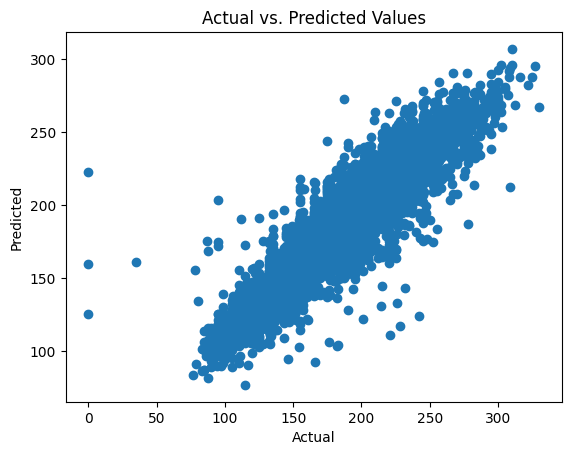

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_event3, Y_event3, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVR model
svr = SVR(kernel='linear')

# For Poly, default value of degree is 3, capturing cubic relationships.

# A smaller C value allows for a wider margin but may tolerate more margin violations.
# A larger C value enforces a narrower margin, which may lead to fewer margin violations but could overfit the data.

# A smaller epsilon value results in a narrower tube, making the model less tolerant of prediction errors.
# A larger epsilon value creates a wider tube, allowing for greater flexibility and tolerance to errors.


# Define a grid of hyperparameter values to search
param_grid = {
    'kernel': ['linear', 'poly'],  # Different kernel functions
    'C': [0.1, 1, 10],              # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5]    # Margin width
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']
best_epsilon = best_params['epsilon']

print("Best Kernel:", best_kernel)
print("Best C:", best_C)
print("Best Epsilon:", best_epsilon)

# Create and train the SVR model with the best hyperparameters
best_svr = SVR(kernel=best_kernel, C=best_C, epsilon=best_epsilon)
best_svr.fit(X_train, y_train)

# Make predictions
y_pred = best_svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

## Thoughts on Event 3

In the case of Event 3, we can see that the models have a high r-squre for Linear, Poynomial, Elastic Net and SVR. We should not discredit the predictor variables as they contribute significantly to the model's performance.

For Event 3, similarly to Event 1, based on the MSE and r-square to evaluate the elastic net regression model, the RMSE is low, which indicates a low margin for errors. Also, we can see the same happening for the SVR model as the RMSE is also low, and the r-square indicates an adequate model. Overall, the models for Event 3 are good models to predict the 1-rep max thruster. However, we must them take with a grain of salt due to the multicollinearity of the lifts as it can render down their statistical significance.

 Although all metrics are fairly similar across models, the best model would be the Elastic Net Model using polynomial degree 3 transformed data as it yields the highest r-square and the lowest RMSE.

## Conclusion for Objective 1

It is fair to assume that there should be more factors that needs to be considered in properly predicting athletes' performance scores. This is not to say that the predictor variables that we have selected are not relevant as they show to be statistically significant to the target variable. However, the model would require more variables to predict more accurately the scores.

The only Event Score that we can possibly predict would be for Event 3 as the predictors we have prove that they impact the target variable despite multicollinearity.

We can confidently conclude that accurately predicting scores is difficult as there are much more factors of an athlete that needs to be considered. Another way to improve this model would be to limit the number of correlated variables as they do not necessarily add much value to the model. Diversifying the variables would provide a better picture of an athlete, which then help us assess their performance.

Examples of new predictors would be quality of recovery, mental readiness, diet, gymnastics benchmark scores and cardiovascular benchmark scores.

# Objective 2 - Prediction of the Qualification Status

Based the athlete's physique and benchmark scores, we will determine whether they qualify for the QuarterFinals. As illustrated in the correlation matrix, it seems that there is very little correlation between these features and the qualification status. However, we will try to run several models to see if we can accurately predict whether they qualify or not.

Objective 2 is as follows:

CrossFit is a multidisciplinary sport that touches many fitness areas, mainly gymnastics, Olympic weightlifting and cardiovascular endurance. For CrossFit newcomers, with prior athletic experience, we would also want to know how well they would have performed in the Open 2023 tests. As such, we will use predictive modelling to evaluate their potential and if they would have qualified for the next round.

In [34]:
qualification_df = CFOpenAthletesStats_df
qualification_df = qualification_df[['Gender','Age','HeightInCm','WeightInKg','BMI','QualifiedForQF','BackSquatInKg','CleanAndJerkInKg','SnatchInKg','DeadliftInKg']]

For the qualification status, we will split the data into each gender and remove the gender as a predictor variable. We are doing this, because each gender are treated separately and the gender should not have an impact on whether the athlete will qualify or not.

In [35]:
male_qualifcation_df = qualification_df[qualification_df['Gender']=='M']
male_qualifcation_df = male_qualifcation_df.drop('Gender',axis=1)
female_qualifcation_df = qualification_df[qualification_df['Gender']=='F']
female_qualifcation_df = female_qualifcation_df.drop('Gender',axis=1)

In [50]:
X_male_qualification_df = male_qualifcation_df.drop('QualifiedForQF',axis=1)
Y_male_qualification_df = male_qualifcation_df['QualifiedForQF']
X_female_qualification_df = female_qualifcation_df.drop('QualifiedForQF',axis=1)
Y_female_qualification_df = female_qualifcation_df['QualifiedForQF']

## Male Athletes

|Method  |Description   |Selected?| 
|---|---|---|
|Logistic Regression| It is considerd the baseline model for binary classification. It uses linear relationship between the predictors and the target.|   |
|Random Forest|Random Forest uses decision trees to make predictions and can be used for regression and classification.|   |
|Gradient Boosting|Gradient Boosting learns from a combination of models (usually decision trees) to build its prediction model.|✓  |
|Support Vector Machine|SVM is a method that finds a hyperplane that separates the data into the required classes while maximizing the margin between the classes.It is appropriate for non-linear data.|   |
|Neural Network|Neural Network uses layers of interconnected nodes to learn complex patterns in large datasets.| |



### Logistic Regression

Logistic Regression will be used as baseline model as it is the simplest linear model used for binary or multi-class classification.

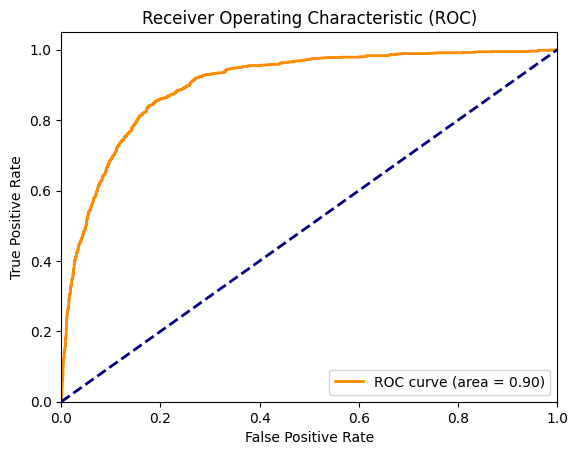

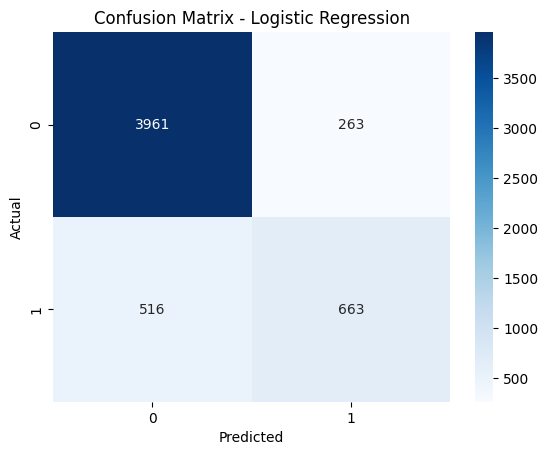

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

       False       0.88      0.94      0.91      4224
        True       0.72      0.56      0.63      1179

    accuracy                           0.86      5403
   macro avg       0.80      0.75      0.77      5403
weighted avg       0.85      0.86      0.85      5403



In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)

# Create and train the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Logistic Regression:\n", classification_rep)

### Random Forest

Random Forest is a good method that uses the decision tree approach to do the classification.

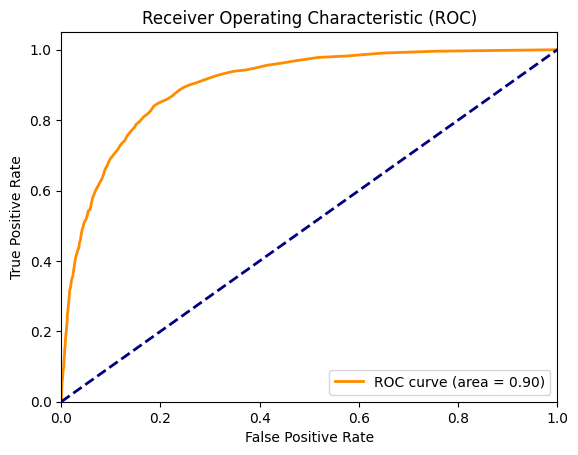

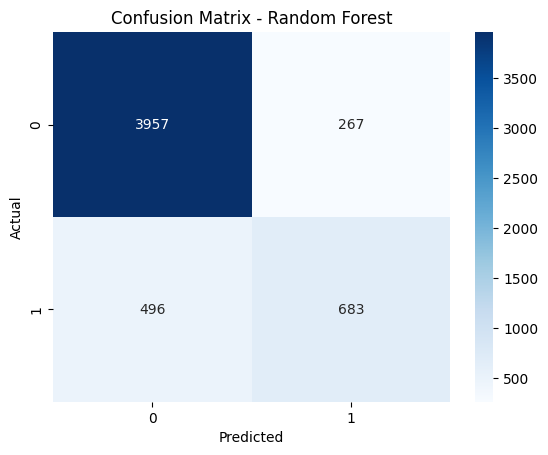

Classification Report - Random Forest:
               precision    recall  f1-score   support

       False       0.89      0.94      0.91      4224
        True       0.72      0.58      0.64      1179

    accuracy                           0.86      5403
   macro avg       0.80      0.76      0.78      5403
weighted avg       0.85      0.86      0.85      5403



In [86]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Random Forest:\n", classification_rep)


### Gradient Boosting

Gradient Boosting a great classification model as it handles complex nonlinear relationships in data. The advantage of gradient boosting is that it learns from iterations of several machine learning models.

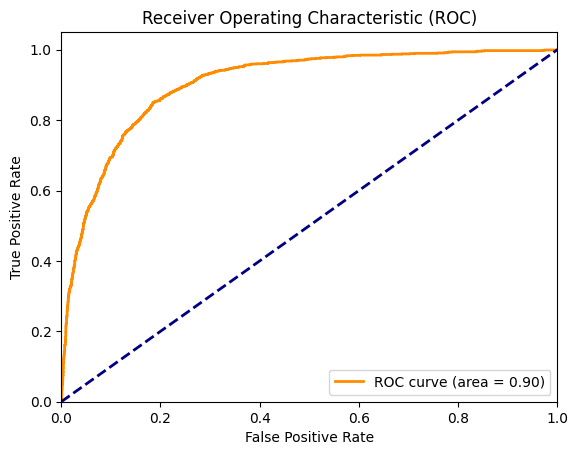

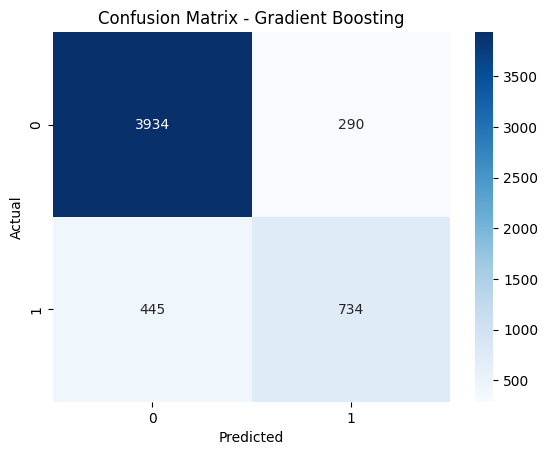

Classification Report - Gradient Boosting:
               precision    recall  f1-score   support

       False       0.90      0.93      0.91      4224
        True       0.72      0.62      0.67      1179

    accuracy                           0.86      5403
   macro avg       0.81      0.78      0.79      5403
weighted avg       0.86      0.86      0.86      5403



In [115]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)


# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)
y_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = gb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Gradient Boosting:\n", classification_rep)

### Support Vector Machine (SVM)

SVM is a generally a good classification model for structured data with complex relationships. However, it is best used for high-dimensional datasets, which is not the case for us. But, it would be interesting to see how it performs.

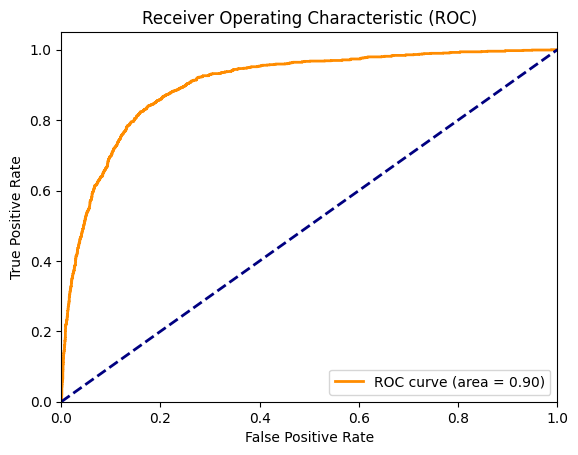

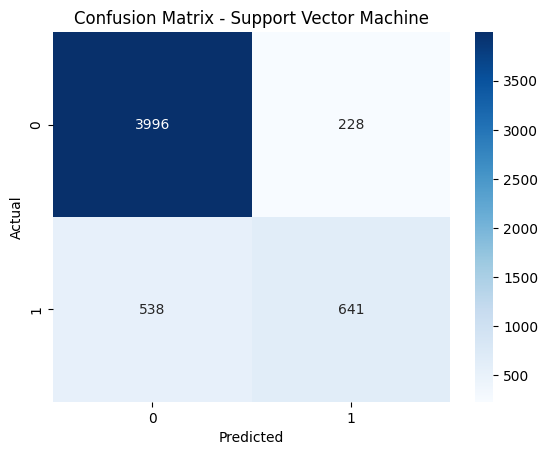

Classification Report - Support Vector Machine:
               precision    recall  f1-score   support

       False       0.88      0.95      0.91      4224
        True       0.74      0.54      0.63      1179

    accuracy                           0.86      5403
   macro avg       0.81      0.74      0.77      5403
weighted avg       0.85      0.86      0.85      5403



In [91]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Support Vector Machine:\n", classification_rep)

### Neural Network

With neural network, it can help us decypher the complex relationships in the data. In fact, with the current predictors, two athletes could have the same variables, but either one of them won't necessarily qualify. These little details could be captured with neural network. In our case, since we have continuous data, it is best to use the dense layers and adjust the number of nodes and layers to optimize the model.

169/169 [==============================] - 0s 1ms/step


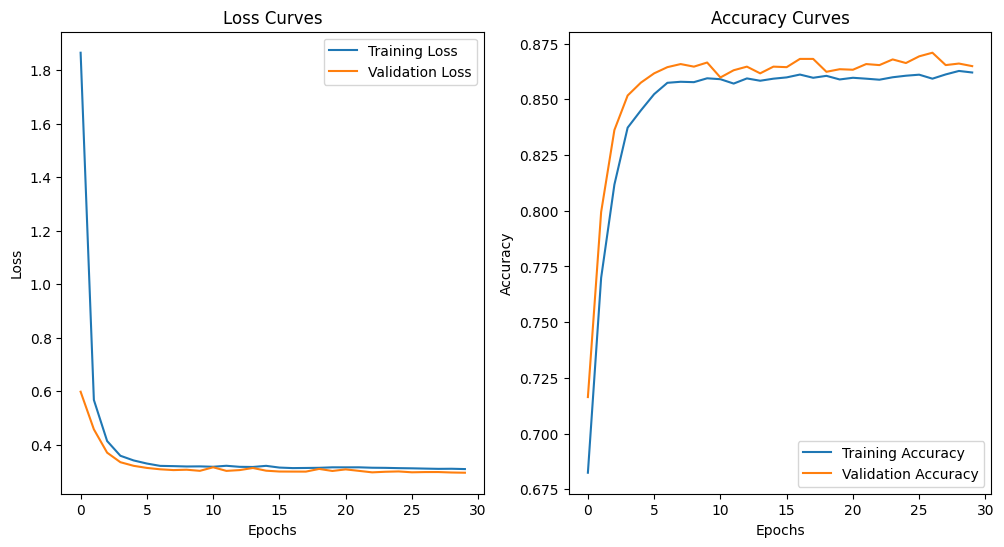

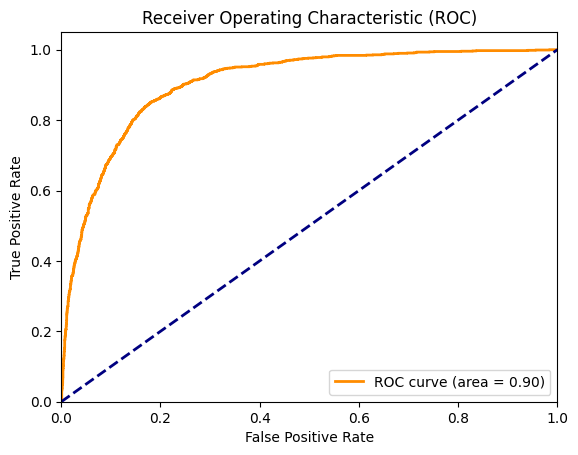

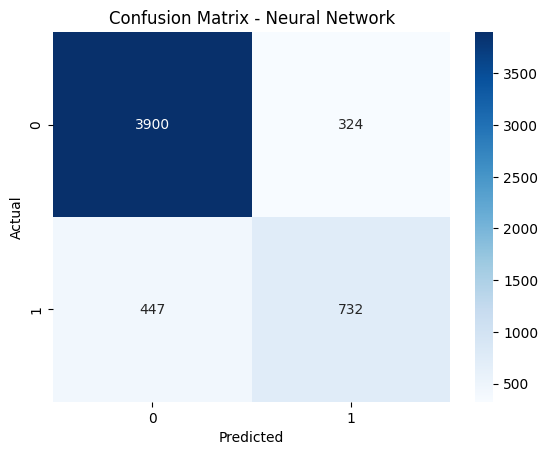

Classification Report - Neural Network:
               precision    recall  f1-score   support

       False       0.90      0.92      0.91      4224
        True       0.69      0.62      0.66      1179

    accuracy                           0.86      5403
   macro avg       0.80      0.77      0.78      5403
weighted avg       0.85      0.86      0.85      5403



In [169]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)

# Get number of columns in the qualification dataframe
num_features = len(X_male_qualification_df.columns)

# Create a neural network model
nn_model = keras.Sequential(
    [
    layers.Input(shape=(num_features,)),
    #layers.Dense(1024, activation='relu'),
    #layers.Dense(512, activation='relu'),
    #layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
    ]
)

# Compile the model
nn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# Train the model
qualification_model = nn_model.fit(X_train, y_train, epochs=30, batch_size=2048, verbose=0, validation_split=0.2)

# Predict probabilities
y_pred_prob = nn_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(qualification_model.history['loss'], label='Training Loss')
plt.plot(qualification_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(qualification_model.history['accuracy'], label='Training Accuracy')
plt.plot(qualification_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Neural Network:\n", classification_rep)

## Thoughts on Male Qualification Models

To evaluate the models, we will compare the ROC curve, AUC as well as the performance metrics of the classification reports.

Based on the ROC Curve, all models look the same and the AUC is the same for all. With an AUC of 0.9, the models are performing well and are deemed as good classifiers.

Next, we have the classification report. As a reminder, the key metrics are precision, recall, f1-score and accuracy. Precision measures how accurate the model can predict the actual values (TP/(TP+FP)). Recall measures how accurate the model was to identify the actual values (TP/(TP+FN)). The F1-Score is a harmonic mean between precision and recall. Lastly, accuracy is the overally accuracy, which measures how accurate were the classified instances.

Across all models, the accuracy is around 85-86%. What is important here is to properly classify the qualified ones. Therefore, we will select based on the better recall and f1-score for 'True'. In this case, the Gradient Boosting is the better model.



## Female Athletes

Similarly to the male qualification models, we will use the same models to do the model selection for the female qualification model.

|Method  |Description   |Selected?| 
|---|---|---|
|Logistic Regression| It is considerd the baseline model for binary classification. It uses linear relationship between the predictors and the target.|   |
|Random Forest|Random Forest uses decision trees to make predictions and can be used for regression and classification.|   |
|Gradient Boosting|Gradient Boosting learns from a combination of models (usually decision trees) to build its prediction model.|✓  |
|Support Vector Machine|SVM is a method that finds a hyperplane that separates the data into the required classes while maximizing the margin between the classes.It is appropriate for non-linear data.|   |
|Neural Network|Neural Network uses layers of interconnected nodes to learn complex patterns in large datasets.| |

### Logistic Regression

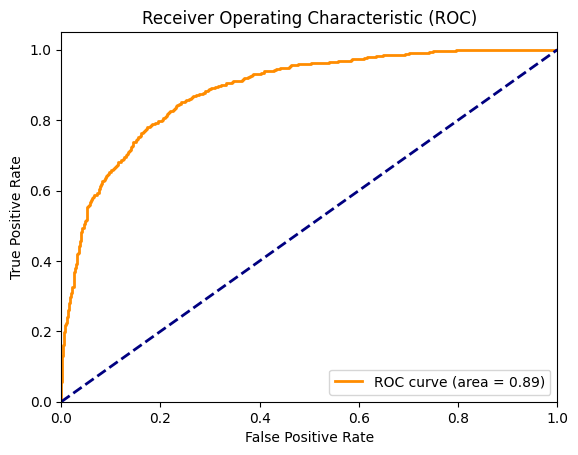

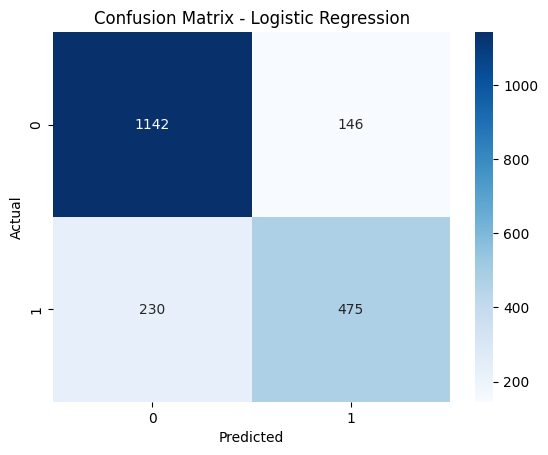

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

       False       0.83      0.89      0.86      1288
        True       0.76      0.67      0.72       705

    accuracy                           0.81      1993
   macro avg       0.80      0.78      0.79      1993
weighted avg       0.81      0.81      0.81      1993



In [57]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)

# Create and train the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Logistic Regression:\n", classification_rep)

### Random Forest

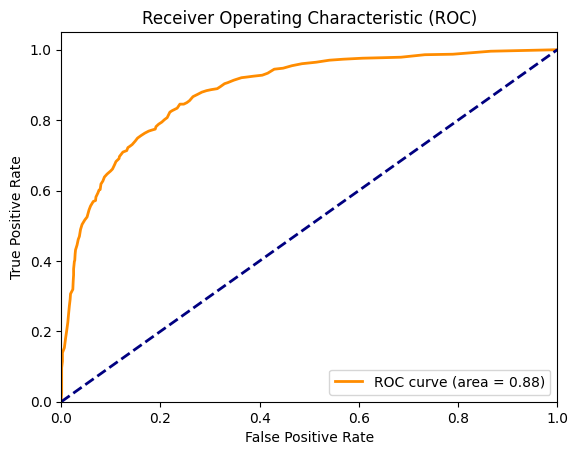

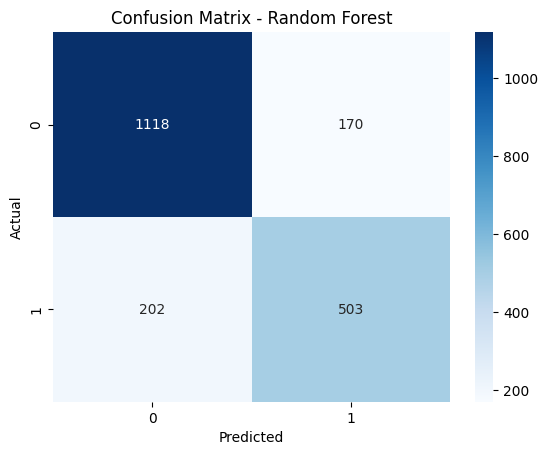

Classification Report - Random Forest:
               precision    recall  f1-score   support

       False       0.85      0.87      0.86      1288
        True       0.75      0.71      0.73       705

    accuracy                           0.81      1993
   macro avg       0.80      0.79      0.79      1993
weighted avg       0.81      0.81      0.81      1993



In [119]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Random Forest:\n", classification_rep)


### Gradient Boosting

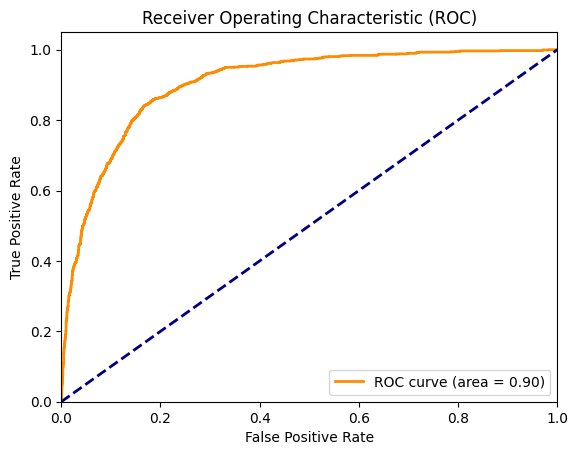

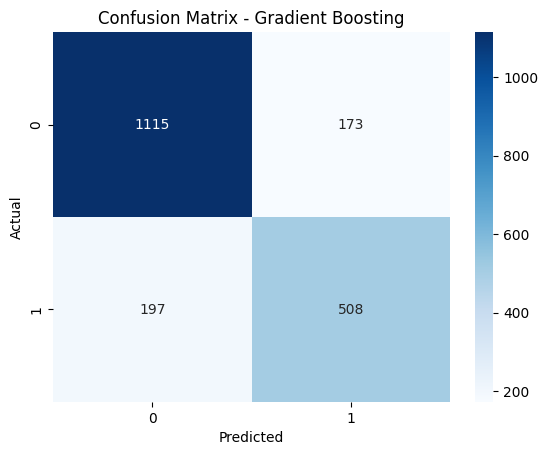

Classification Report - Gradient Boosting:
               precision    recall  f1-score   support

       False       0.85      0.87      0.86      1288
        True       0.75      0.72      0.73       705

    accuracy                           0.81      1993
   macro avg       0.80      0.79      0.80      1993
weighted avg       0.81      0.81      0.81      1993



In [121]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)


# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)
y_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = gb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Gradient Boosting:\n", classification_rep)

### Support Vector Machine (SVM)

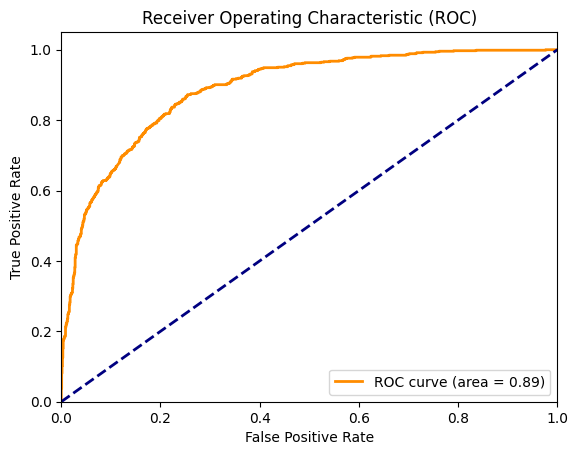

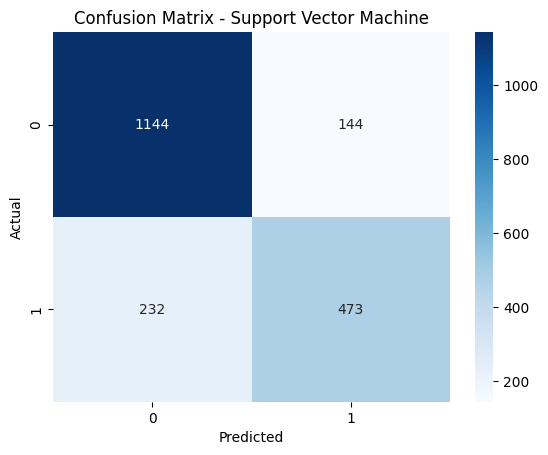

Classification Report - Support Vector Machine:
               precision    recall  f1-score   support

       False       0.83      0.89      0.86      1288
        True       0.77      0.67      0.72       705

    accuracy                           0.81      1993
   macro avg       0.80      0.78      0.79      1993
weighted avg       0.81      0.81      0.81      1993



In [122]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

# Predict probabilities and compute ROC curve
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Support Vector Machine:\n", classification_rep)

### Neural Network

63/63 [==============================] - 0s 1ms/step


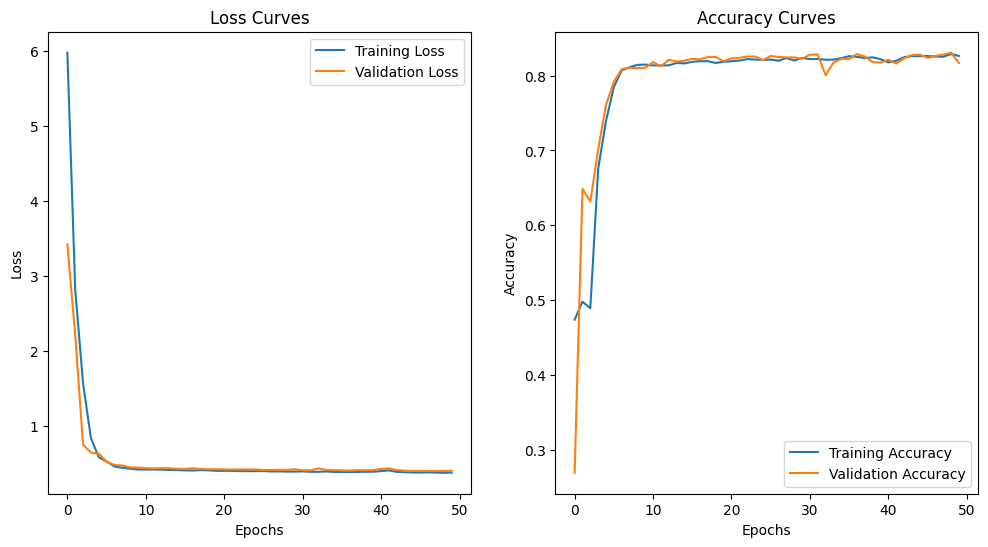

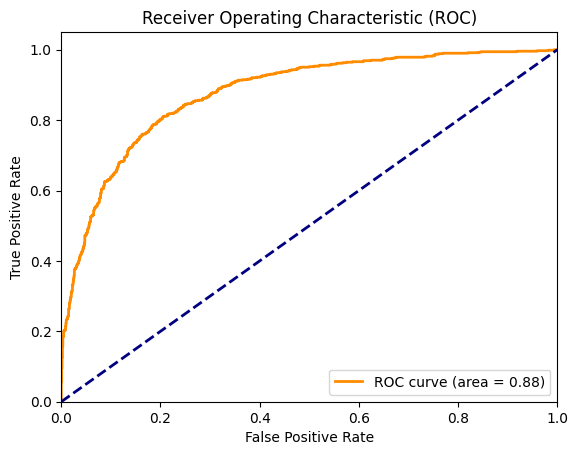

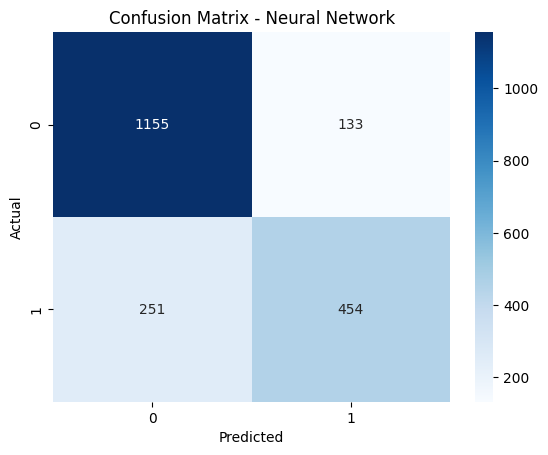

Classification Report - Neural Network:
               precision    recall  f1-score   support

       False       0.82      0.90      0.86      1288
        True       0.77      0.64      0.70       705

    accuracy                           0.81      1993
   macro avg       0.80      0.77      0.78      1993
weighted avg       0.80      0.81      0.80      1993



In [162]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)

# Get number of columns in the qualification dataframe
num_features = len(X_male_qualification_df.columns)

# Create a neural network model
nn_model = keras.Sequential(
    [
    layers.Input(shape=(num_features,)),
    #layers.Dense(1024, activation='relu'),
    #layers.Dense(512, activation='relu'),
    #layers.Dense(256, activation='relu'),
    #layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
    ]
)

# Compile the model
nn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# Train the model
qualification_model = nn_model.fit(X_train, y_train, epochs=50, batch_size=1024, verbose=0, validation_split=0.2)

# Predict probabilities
y_pred_prob = nn_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(qualification_model.history['loss'], label='Training Loss')
plt.plot(qualification_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(qualification_model.history['accuracy'], label='Training Accuracy')
plt.plot(qualification_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Neural Network:\n", classification_rep)

## Thoughts on Female Qualification Models

To evaluate the models, we will compare the ROC curve, AUC as well as the performance metrics of the classification reports.

Based on the ROC Curve, all models look the same and the AUC is the same for all. With an AUC of 0.88-0.90, the models are performing well and are deemed as good classifiers. The better one is Gradient Boosting.

Next, we have the classification report. As a reminder, the key metrics are precision, recall, f1-score and accuracy. Precision measures how accurate the model can predict the actual values (TP/(TP+FP)). Recall measures how accurate the model was to identify the actual values (TP/(TP+FN)). The F1-Score is a harmonic mean between precision and recall. Lastly, accuracy is the overally accuracy, which measures how accurate were the classified instances.

Across all models, the accuracy is 81%. What is important here is to properly classify the qualified ones. Therefore, we will select based on the better f1-score for 'True'. In this case also, the Gradient Boosting is the better model.



## Final Thoughts

For objective 2, although all models performed well, the Gradient Boosting model was the better choice. For fine-tuning, implementing GridSearch to get the best hyperparameters in each model will be the best approach. However, as observed in Objective 1, our analysis will benefit significantly from a bigger set of variables to look at. 

The data publicly available on the CrossFit website is simply insufficient to assess an athlete's fitness level based purely on their physique and lifts. CrossFit is a multidisciplinary sport. Even though we had information on some other benchmark scores, not enough data was entered to make a proper analysis without compromising the quality of the data.

Furthermore, the data is entered manually by the athletes and is therfore prone to human error, resulting to data quality issues.

With more data and predictors, implementing dimensionality reduction will then be a possibility without compromising the quality of the data. While testing some models with PCA, we observed poorer model performance and the processing time was not significantly reduced.

As suggested, examples of new predictors would be quality of recovery, VO2 Max, heart rate variability, blood oxygen level, mental readiness, diet, gymnastics benchmark scores and cardiovascular benchmark scores. These key metrics will give a better overall picture of an athlete's fitness and, with this kind of data, we would be able to evaluate and better predict their performance.

# Model Deployment

Due to 'HTTP ERROR 403' error, the models couldn't be run on a browser. The tests were done manually after each model deployment.

## Event 3 Model (Elastic Net Model with Transformed Data)

Best Alpha: 0.001
Best L1 Ratio: 0.6

Root Mean Squared Error (RMSE): 16.029929348348766
R-squared: 0.8679114986566802


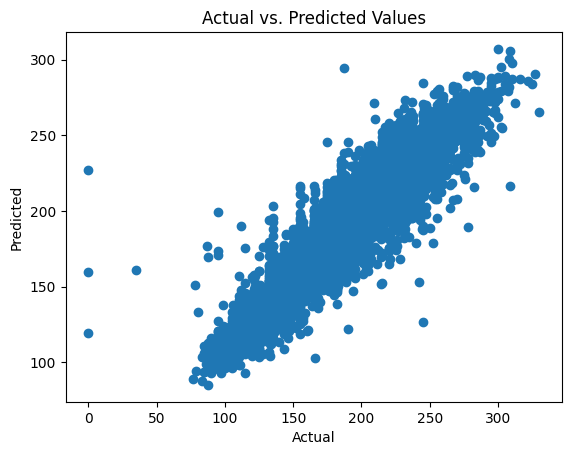

In [151]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_event3, Y_event3, test_size=0.2, random_state=42)

event3_model_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('poly',PolynomialFeatures(degree=3, include_bias=False)),
    ('model',ElasticNet(alpha=0.001,l1_ratio=0.6))
])

event3_model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = event3_model_pipeline.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

In [152]:
# Saving our model 
file_name = 'event3_model'

with open(file_name, 'wb') as file:
    pickle.dump(event3_model_pipeline,file)

In [141]:
X_event3.columns

Index(['Age', 'HeightInCm', 'WeightInKg', 'BackSquatInKg', 'CleanAndJerkInKg',
       'SnatchInKg', 'DeadliftInKg', 'IsMale'],
      dtype='object')

In [161]:
event_3_test = [29,175,89,215,171,132,257,1]
event_3_array = np.array(event_3_test)

event_3_array = event_3_array.reshape(1,-1)

event3_model_pipeline.predict(event_3_array)

array([281.32238562])

## Male Athlete Qualification Model (Gradient Boosting Model)

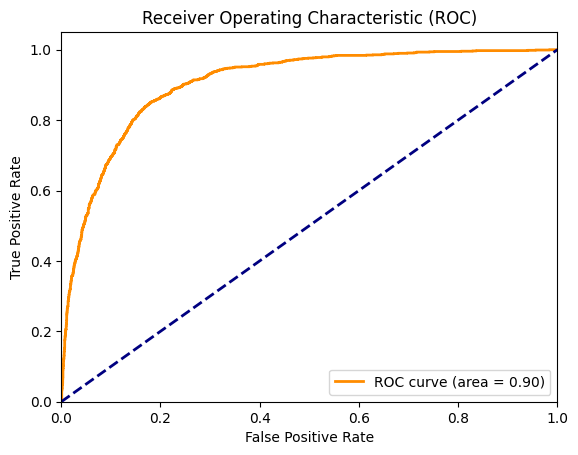

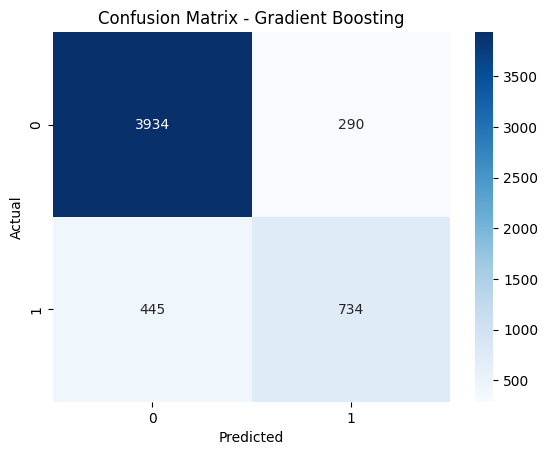

Classification Report - Gradient Boosting:
               precision    recall  f1-score   support

       False       0.90      0.93      0.91      4224
        True       0.72      0.62      0.67      1179

    accuracy                           0.86      5403
   macro avg       0.81      0.78      0.79      5403
weighted avg       0.86      0.86      0.86      5403



In [170]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_male_qualification_df, Y_male_qualification_df, test_size=0.2, random_state=42)


# Create a Gradient Boosting Classifier
male_qualification_gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
male_qualification_gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = male_qualification_gb_classifier.predict(X_test)
y_prob = male_qualification_gb_classifier.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = male_qualification_gb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Gradient Boosting:\n", classification_rep)

In [171]:
# Saving our model 
file_name = 'male_qualification_model'

with open(file_name, 'wb') as file:
    pickle.dump(male_qualification_gb_classifier,file)

In [172]:
X_male_qualification_df.columns

Index(['Age', 'HeightInCm', 'WeightInKg', 'BMI', 'BackSquatInKg',
       'CleanAndJerkInKg', 'SnatchInKg', 'DeadliftInKg'],
      dtype='object')

In [174]:
male_qualification_test = [29,175,89,29.1,215,171,132,257]
male_qualification_array = np.array(male_qualification_test)

male_qualification_array = male_qualification_array.reshape(1,-1)

male_qualification_gb_classifier.predict(male_qualification_array)

array([ True])

In [176]:
male_qualification_test = [25,185,88,25.7,140,102,85,200]
male_qualification_array = np.array(male_qualification_test)

male_qualification_array = male_qualification_array.reshape(1,-1)

male_qualification_gb_classifier.predict(male_qualification_array)

array([False])

## Female Athlete Qualification Model (Gradient Boosting Model)

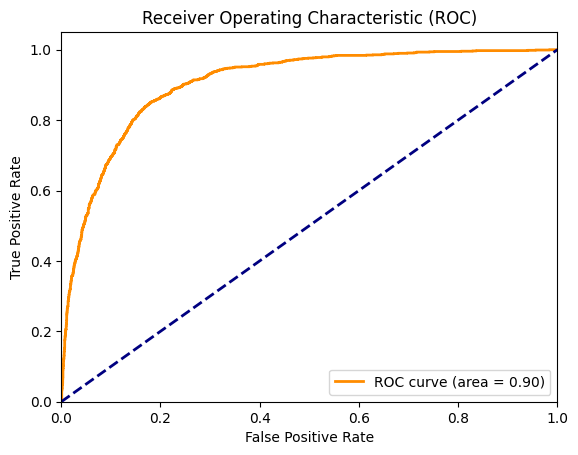

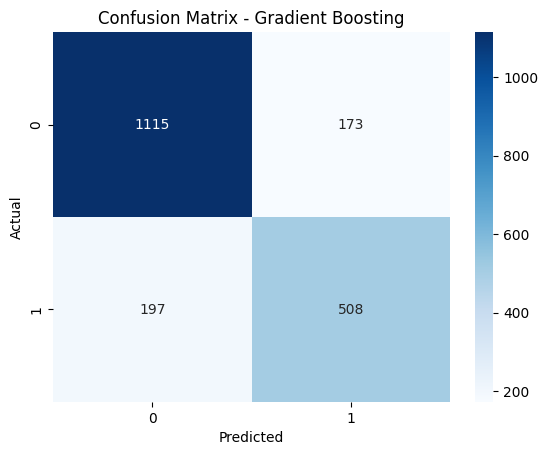

Classification Report - Gradient Boosting:
               precision    recall  f1-score   support

       False       0.85      0.87      0.86      1288
        True       0.75      0.72      0.73       705

    accuracy                           0.81      1993
   macro avg       0.80      0.79      0.80      1993
weighted avg       0.81      0.81      0.81      1993



In [177]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_female_qualification_df, Y_female_qualification_df, test_size=0.2, random_state=42)


# Create a Gradient Boosting Classifier
female_qualification_gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
female_qualification_gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = female_qualification_gb_classifier.predict(X_test)
y_prob = female_qualification_gb_classifier.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = female_qualification_gb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report - Gradient Boosting:\n", classification_rep)

In [178]:
# Saving our model 
file_name = 'female_qualification_model'

with open(file_name, 'wb') as file:
    pickle.dump(female_qualification_gb_classifier,file)

In [179]:
X_female_qualification_df.columns

Index(['Age', 'HeightInCm', 'WeightInKg', 'BMI', 'BackSquatInKg',
       'CleanAndJerkInKg', 'SnatchInKg', 'DeadliftInKg'],
      dtype='object')

In [180]:
female_qualification_test = [33,160,66,25.8,150,104,86,181]
female_qualification_array = np.array(female_qualification_test)

female_qualification_array = male_qualification_array.reshape(1,-1)

female_qualification_gb_classifier.predict(female_qualification_array)

array([ True])

In [193]:
female_qualification_test = [38,173,70,23.4,73,59,36,98]
female_qualification_array = np.array(female_qualification_test)

female_qualification_array = female_qualification_array.reshape(1,-1)

female_qualification_gb_classifier.predict(female_qualification_array)

array([False])